In [2]:
import collections
import gc
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [4]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.BinnedTestSetSplitter import BinnedTestSetSplitter
    from reservoir.BasicESNCuda import BasicESNCuda as BasicESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from binnedtestsetsplitter.binnedtestsetsplitter import BinnedTestSetSplitter
    from basicesncuda.basicesncuda import BasicESNCuda as BasicESN
    from esnutil.esnutil import generate_input_weights

In [5]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib

In [6]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


In [7]:
if is_kaggle:
    data_path = '/kaggle/input/har70'
else:
    data_path = os.path.abspath(os.path.join('..', 'data'))

In [8]:
if not is_kaggle:
    # Download data
    downloader = DataDownloader()
    downloader.download_data('har70plus', data_path)

Dataset already downloaded


In [9]:
# Collect data into dataframes
collector = DataframeCollector()
collector.load_full_dataset(data_path + '/har70plus')

Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data/har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes


timestamp    back_x    back_y    back_z   thigh_x  \
0        2021-03-24 14:42:03.839 -0.999023 -0.063477  0.140625 -0.980469   
1        2021-03-24 14:42:03.859 -0.980225 -0.079346  0.140625 -0.961182   
2        2021-03-24 14:42:03.880 -0.950195 -0.076416  0.140625 -0.949463   
3        2021-03-24 14:42:03.900 -0.954834 -0.059082  0.140381 -0.957520   
4        2021-03-24 14:42:03.920 -0.972412 -0.042969  0.142822 -0.977051   
...                          ...       ...       ...       ...       ...   
2259592  2021-06-11 11:13:14.098 -0.960693 -0.199951 -0.330566 -0.977051   
2259593  2021-06-11 11:13:14.118 -0.942627 -0.210205 -0.331543 -0.969482   
2259594  2021-06-11 11:13:14.138 -0.907227 -0.190918 -0.320312 -1.048096   
2259595  2021-06-11 11:13:14.159 -0.883057 -0.156982 -0.311279 -1.007080   
2259596  2021-06-11 11:13:14.178 -0.877197 -0.128418 -0.315186 -0.995361   

          thigh_y   thigh_z  label  record_num  
0       -0.112061 -0.048096      6           0  
1       -0.121582 -0.051758      6           1  
2       -0.080566 -0.067139      6           2  
3       -0.046143 -0.050781      6           3  
4       -0.023682 -0.026611      6           4  
...           ...       ...    ...         ...  
2259592  0.006104 -0.246826      1     2259592  
2259593  0.004883 -0.231445      1     2259593  
2259594  0.067627 -0.234375      1     2259594  
2259595  0.063965 -0.248047      1     2259595  
2259596  0.083496 -0.232178      1     2259596  

[2259597 rows x 9 columns]

In [10]:
dataframes = collector.get_dataframes()
full_data = collector.get_collected_data()

features = full_data[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'record_num', 'timestamp']]
labels = full_data['label']

test_split = 0.2
train_split = 1 - test_split
validation_split = 0.2

validation_from_train = True
use_slices = False

splitter = TestSetSplitter(test_split=test_split, val_split=validation_split, val_from_train=validation_from_train,
                           seed=1234)
train, val, test = splitter.split(dataframes, use_slices=use_slices)

Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]


In [11]:
# Normally, the data would be fed into the echo state network as it comes, but for this baseline, we will just use a ridge regression model
# to predict the labels from the features, without any temporal information

# We will use the train set to train the model and the validation set to tune the hyperparameters

In [12]:
# Prepare each dataset
input_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_columns = ['label']

train_df = pd.concat(train)
val_df = pd.concat(val)
test_df = pd.concat(test)

X_train = train_df[input_columns].values
y_train = train_df[output_columns].values.ravel()

X_val = val_df[input_columns].values
y_val = val_df[output_columns].values.ravel()

X_test = test_df[input_columns].values
y_test = test_df[output_columns].values.ravel()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1357646, 6)
y_train shape: (1357646,)
X_val shape: (339404, 6)
y_val shape: (339404,)
X_test shape: (562547, 6)
y_test shape: (562547,)


In [13]:
# We will one-hot encode the labels for the ridge regression model
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto')

encoder.fit(y_train.reshape(-1, 1))

y_train_encoded = encoder.transform(y_train.reshape(-1, 1)).toarray()
y_val_encoded = encoder.transform(y_val.reshape(-1, 1)).toarray()
y_test_encoded = encoder.transform(y_test.reshape(-1, 1)).toarray()

print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"y_val_encoded shape: {y_val_encoded.shape}")
print(f"y_test_encoded shape: {y_test_encoded.shape}")

# Also, lets prepare a decoded version of the labels for evaluation purposes
y_train_decoded = encoder.inverse_transform(y_train_encoded)
y_val_decoded = encoder.inverse_transform(y_val_encoded)
y_test_decoded = encoder.inverse_transform(y_test_encoded)

y_train_encoded shape: (1357646, 7)
y_val_encoded shape: (339404, 7)
y_test_encoded shape: (562547, 7)


In [14]:
# Let's normalise the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (1357646, 6)
X_val_scaled shape: (339404, 6)
X_test_scaled shape: (562547, 6)


In [15]:
# There is also a class-imbalance in the dataset, so we will use the class weights to balance the classes

from sklearn.utils import compute_class_weight

# Now that all the hyperparameters have been optimised, we can now apply them to the ESN, along with class weights
# The class weights are used to balance the classes in the training data

dataset = collector.get_collected_data()

weight_labels = dataset['label'].values

# Calculate the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(weight_labels), y=labels)

# Print the class weight for each class and the labels

weight_map = {label: weight for label, weight in zip(np.unique(weight_labels), class_weights)}

for label, weight in weight_map.items():
    print(f'Class: {label}, Weight: {weight}')

# We need a list the same length as the number of samples with the class weights
# y and y_val are one-hot encoded
y_class = np.argmax(y_train_encoded, axis=1)
y_val_class = np.argmax(y_val_encoded, axis=1)
y_test_class = np.argmax(y_test_encoded, axis=1)

train_weights = [class_weights[i] for i in y_class]
val_weights = [class_weights[i] for i in y_val_class]
test_weights = [class_weights[i] for i in y_test_class]

Class: 1, Weight: 0.2990790164739866
Class: 3, Weight: 4.886608305255555
Class: 4, Weight: 70.78937969924812
Class: 5, Weight: 64.84523331228836
Class: 6, Weight: 0.7721461803556264
Class: 7, Weight: 0.6676972510788485
Class: 8, Weight: 1.5887213012401267


In [16]:
# Now we can train the ridge regression model
from sklearn.linear_model import Ridge

alphas = np.logspace(-3, 3, 7)

train_scores = []

# We will use the validation set to tune the hyperparameter alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train_encoded, sample_weight=train_weights)
    train_scores.append(ridge.score(X_val_scaled, y_val_encoded, sample_weight=val_weights))

best_alpha = alphas[np.argmax(train_scores)]
print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")

Best alpha: 1000.0 with score: -0.019632102693760034


In [17]:
# Now we can evaluate the model on the test set
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_scaled, y_train_encoded, sample_weight=train_weights)
test_score = ridge.score(X_test_scaled, y_test_encoded, sample_weight=test_weights)

print(f"Test score: {test_score}")

Test score: -0.1306289115600577


In [18]:
# Let's evaluate the model using the decoded labels
y_test_pred_encoded = ridge.predict(X_test_scaled)
y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test_decoded, y_test_pred_decoded))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    346581
           3       0.02      0.07      0.03     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.80      0.00       370
           6       0.45      0.18      0.25    141796
           7       0.63      1.00      0.77     43204
           8       0.43      1.00      0.60      8248

    accuracy                           0.14    562547
   macro avg       0.22      0.44      0.24    562547
weighted avg       0.17      0.14      0.13    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


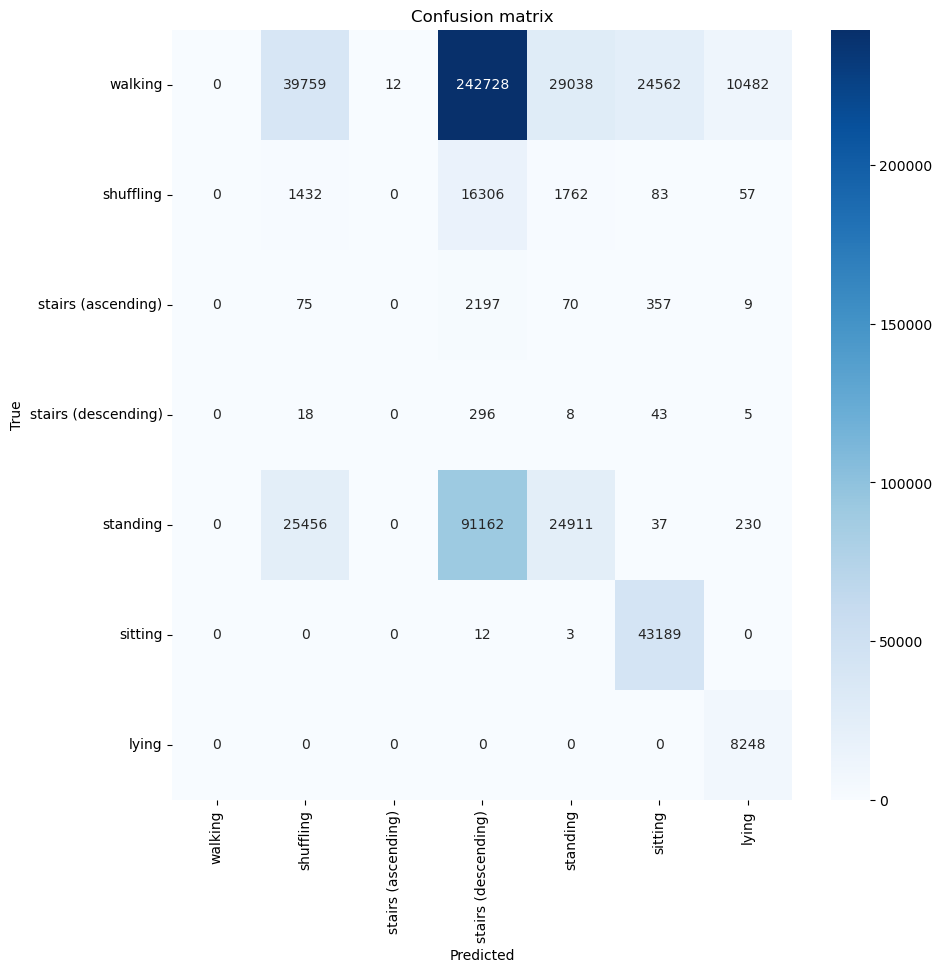

In [20]:
# Let's plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

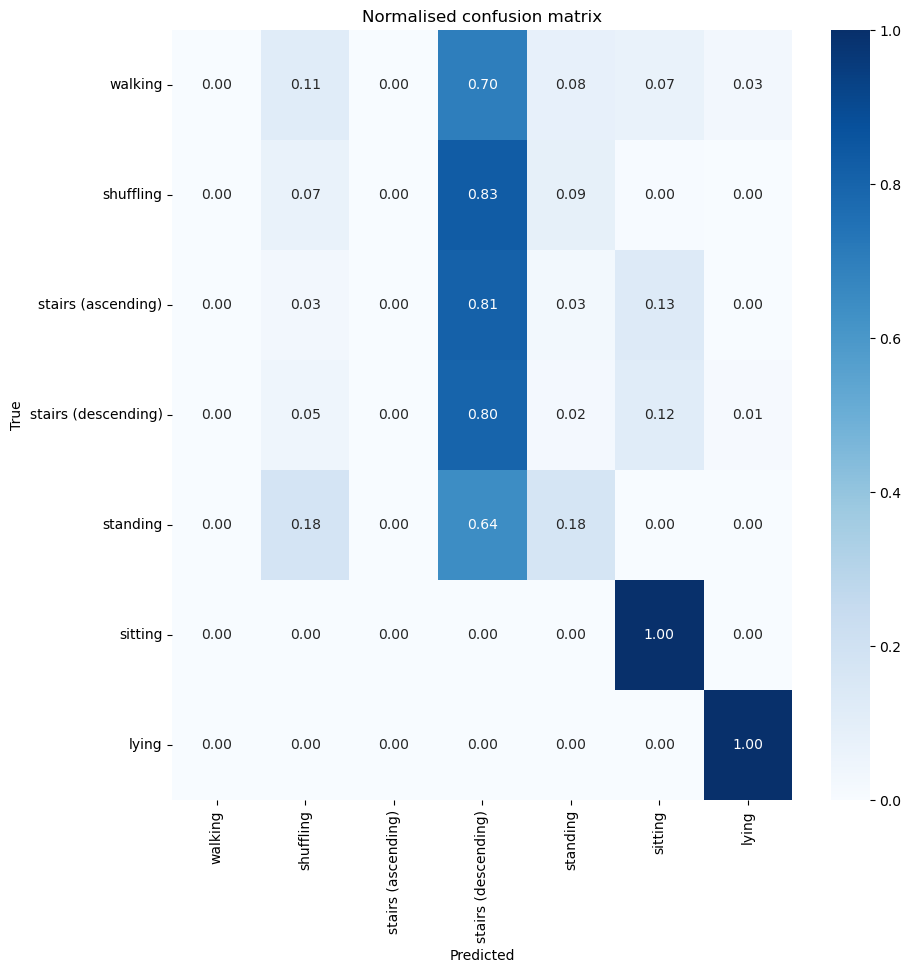

In [21]:
# Let's also print a normalised confusion matrix as there is a class imbalance
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Normalised confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
# This performance is terrible, but it is expected as we are not using any temporal information in the model
# All of the movement classes are predicted as 'stairs (descending)', which makes sense as it is the least common class, so the class weights are boosting the prediction of this class
# Let's try without the class weights to see if it makes a difference

# Re-calculate the best alpha
train_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train_encoded)
    train_scores.append(ridge.score(X_val_scaled, y_val_encoded))
    
best_alpha = alphas[np.argmax(train_scores)]

print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")

Best alpha: 1000.0 with score: -0.1449247682456269


In [23]:
# Evaluate the model on the test set
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_scaled, y_train_encoded)
test_score = ridge.score(X_test_scaled, y_test_encoded)

print(f"Test score: {test_score}")

Test score: 0.07560194993904


In [24]:
# Evaluate the model using the decoded labels
y_test_pred_encoded = ridge.predict(X_test_scaled)
y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

print(classification_report(y_test_decoded, y_test_pred_decoded))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.72      1.00      0.84     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.67    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.67      0.56    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


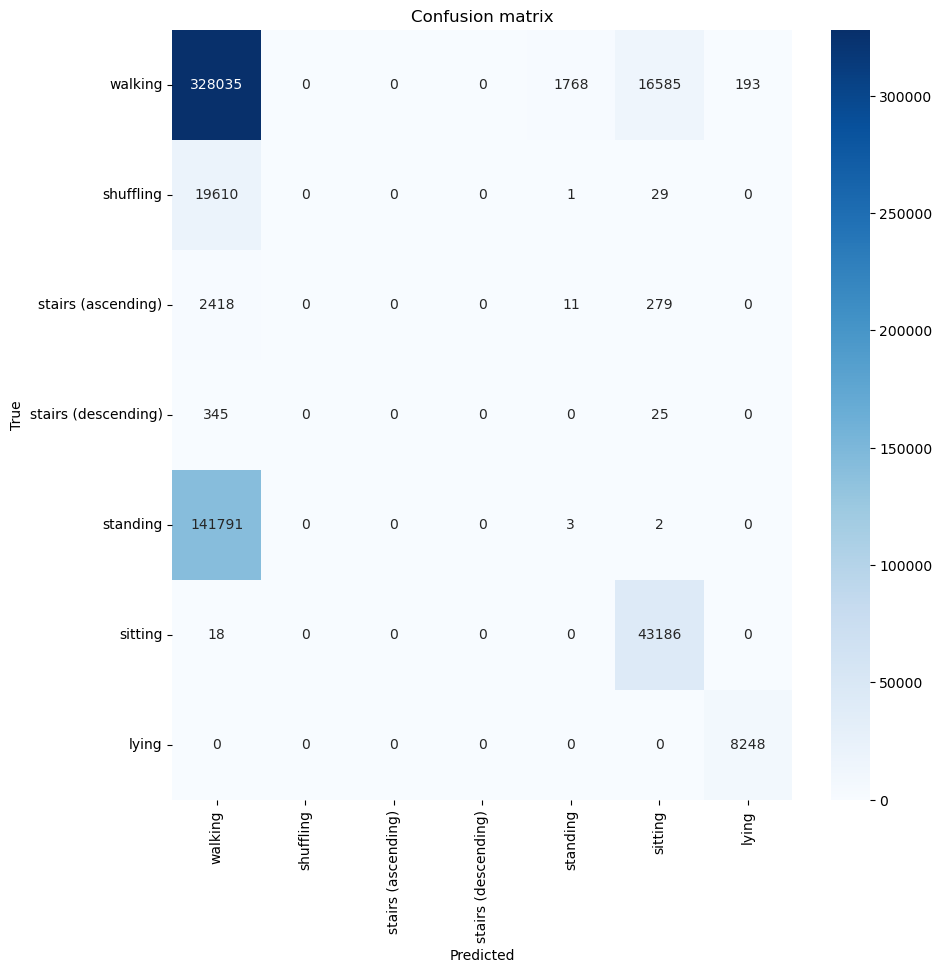

In [25]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

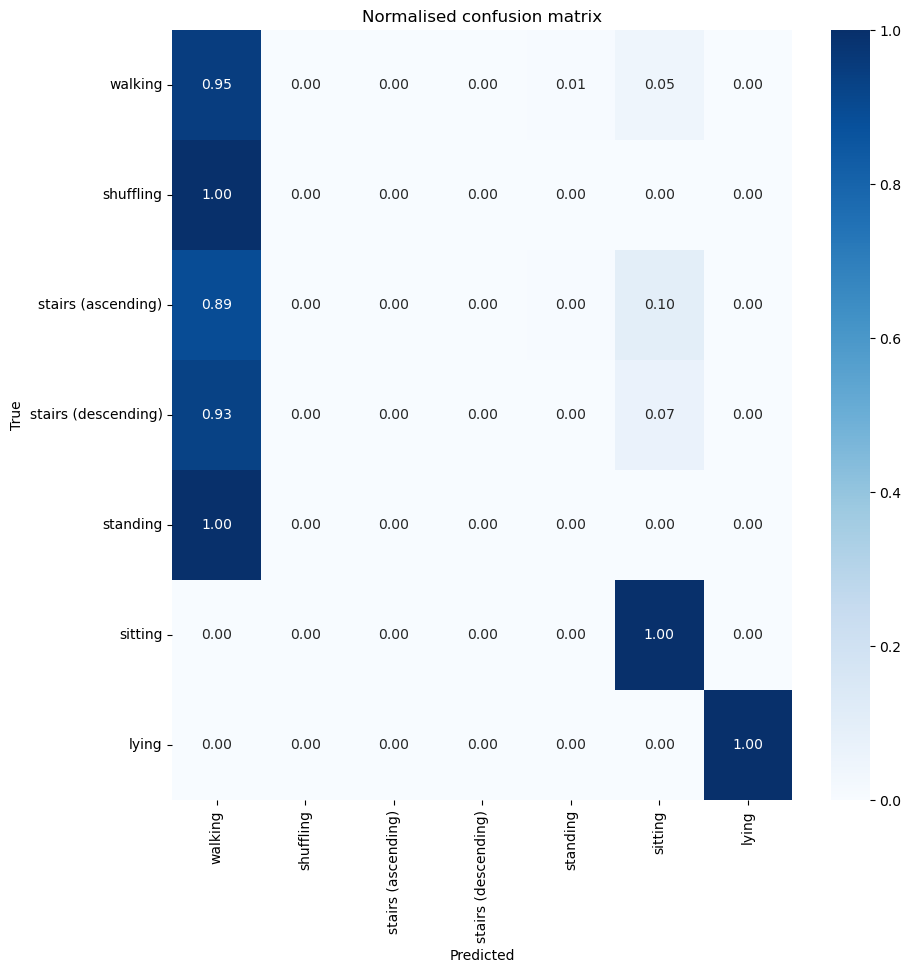

In [26]:
# Normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Normalised confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
# This technically performs better as now the model is predicting all movement activities as 'walking', which is the most common class
# This is not a good model, but it is a good baseline to compare against the ESN model

In [28]:
# We are going to try some preprocessing techniques to see if we can improve the performance of the model
# The first technique is a buffering technique, where we will reshape the data into windows of a certain size, essentially providing N samples of the features for each label
# This will allow the model to learn from the temporal information in the data, as it effectively provides an n-sample memory

# The data is in the shape (n_samples, n_features), we will reshape it to (n_samples//window_size, n_features*window_size)

window_size = 10

def prepare_buffered_data(window_size, x_train, y_train, x_val, y_val, x_test, y_test):
    temp_x_train = x_train.copy()
    temp_y_train = y_train.copy()
    temp_x_val = x_val.copy()
    temp_y_val = y_val.copy()
    temp_x_test = x_test.copy()
    temp_y_test = y_test.copy()
    
    # The data may not exactly fit into the window size, so we will repeat the last sample until it fits
    n_samples = x_train.shape[0]
    n_features = x_train.shape[1]
    
    remainder = n_samples % window_size
    if remainder != 0:
        temp_x_train = np.concatenate([x_train, np.repeat(x_train[-1][np.newaxis, :], window_size - remainder, axis=0)], axis=0)
        
    n_samples = x_val.shape[0]
    remainder = n_samples % window_size
    if remainder != 0:
        temp_x_val = np.concatenate([x_val, np.repeat(x_val[-1][np.newaxis, :], window_size - remainder, axis=0)], axis=0)
        
    n_samples = x_test.shape[0]
    remainder = n_samples % window_size
    if remainder != 0:
        temp_x_test = np.concatenate([x_test, np.repeat(x_test[-1][np.newaxis, :], window_size - remainder, axis=0)], axis=0)
    
    X_train_buffered = np.array([temp_x_train[i:i+window_size].flatten() for i in range(0, temp_x_train.shape[0], window_size)])
    
    X_val_buffered = np.array([temp_x_val[i:i+window_size].flatten() for i in range(0, temp_x_val.shape[0], window_size)])
    
    X_test_buffered = np.array([temp_x_test[i:i+window_size].flatten() for i in range(0, temp_x_test.shape[0], window_size)])
    
    # The labels need to be reshaped as well, each label is one-hot encoded, so we will need to make sure each sample can be associated with a one-hot encoded label
    # The shape of the labels is (n_samples, n_classes), we will reshape it to (n_samples//window_size, n_classes * window_size)
    
    # Similar to the features, we will repeat the last label until it fits
    n_samples = temp_y_train.shape[0]
    n_classes = temp_x_train.shape[1]
    
    remainder = n_samples % window_size
    if remainder != 0:
        temp_y_train = np.concatenate([temp_y_train, np.repeat(temp_y_train[-1][np.newaxis, :], window_size - remainder, axis=0)], axis=0)
        
    n_samples = temp_y_val.shape[0]
    remainder = n_samples % window_size
    if remainder != 0:
        temp_y_val = np.concatenate([temp_y_val, np.repeat(temp_y_val[-1][np.newaxis, :], window_size - remainder, axis=0)], axis=0)
        
    n_samples = temp_y_test.shape[0]
    remainder = n_samples % window_size
    if remainder != 0:
        temp_y_test = np.concatenate([temp_y_test, np.repeat(temp_y_test[-1][np.newaxis, :], window_size - remainder, axis=0)], axis=0)
    
    y_train_buffered = np.array([temp_y_train[i:i+window_size].flatten() for i in range(0, temp_y_train.shape[0], window_size)])
    
    y_val_buffered =  np.array([temp_y_val[i:i+window_size].flatten() for i in range(0, temp_y_val.shape[0], window_size)])
    
    y_test_buffered =  np.array([temp_y_test[i:i+window_size].flatten() for i in range(0, temp_y_test.shape[0], window_size)])

    print(f"Buffered train shape: {X_train_buffered.shape}, {y_train_buffered.shape}")
    print(f"Buffered val shape: {X_val_buffered.shape}, {y_val_buffered.shape}")
    print(f"Buffered test shape: {X_test_buffered.shape}, {y_test_buffered.shape}")

    return X_train_buffered, y_train_buffered, X_val_buffered, y_val_buffered, X_test_buffered, y_test_buffered

X_train_buffered, y_train_buffered, X_val_buffered, y_val_buffered, X_test_buffered, y_test_buffered = prepare_buffered_data(window_size, X_train_scaled, y_train_encoded, X_val_scaled, y_val_encoded, X_test_scaled, y_test_encoded)

Buffered train shape: (135765, 60), (135765, 70)
Buffered val shape: (33941, 60), (33941, 70)
Buffered test shape: (56255, 60), (56255, 70)


In [29]:
# Now we can train the ridge regression model on the buffered data
alphas = np.logspace(-3, 3, 7)

train_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_buffered, y_train_buffered)
    train_scores.append(ridge.score(X_val_buffered, y_val_buffered))
    
best_alpha = alphas[np.argmax(train_scores)]

print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")

ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_buffered, y_train_buffered)
test_score = ridge.score(X_test_buffered, y_test_buffered)

print(f"Test score: {test_score}")

Best alpha: 10.0 with score: 0.03324899155604105
Test score: 0.2078670135044406


In [31]:
# Evaluate the model using the decoded labels
# Before we can evaluate the model, we need to reshape the predictions back to the original shape
y_test_pred_encoded = ridge.predict(X_test_buffered)

n_classes = y_train_encoded.shape[1]

# The shape of the predictions is (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
y_test_pred_encoded = y_test_pred_encoded.reshape(-1, n_classes)

# As we have repeated the last sample to fit the window size, we need to remove the extra samples
y_test_pred_encoded = y_test_pred_encoded[:y_test_encoded.shape[0]]

y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

print(classification_report(y_test_decoded, y_test_pred_decoded))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.69      0.95      0.80    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.50      0.13      0.21    141796
           7       0.98      1.00      0.99     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.71    562547
   macro avg       0.45      0.44      0.43    562547
weighted avg       0.64      0.71      0.64    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


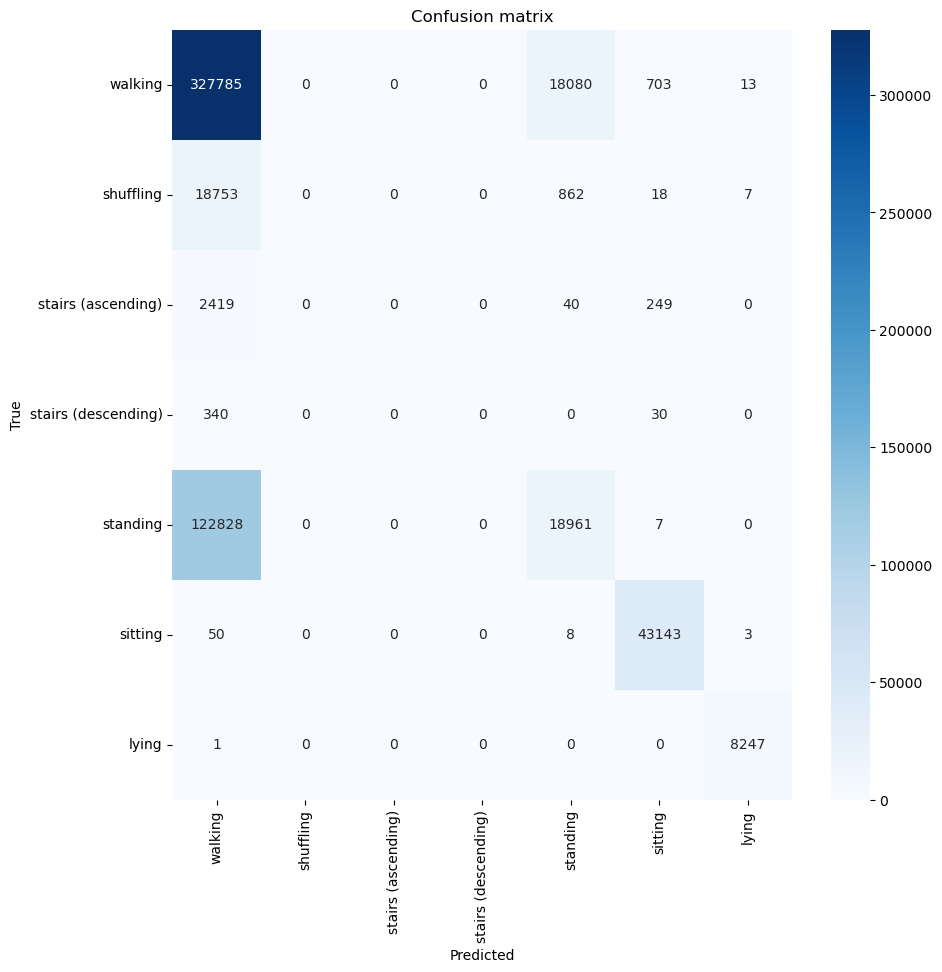

In [32]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

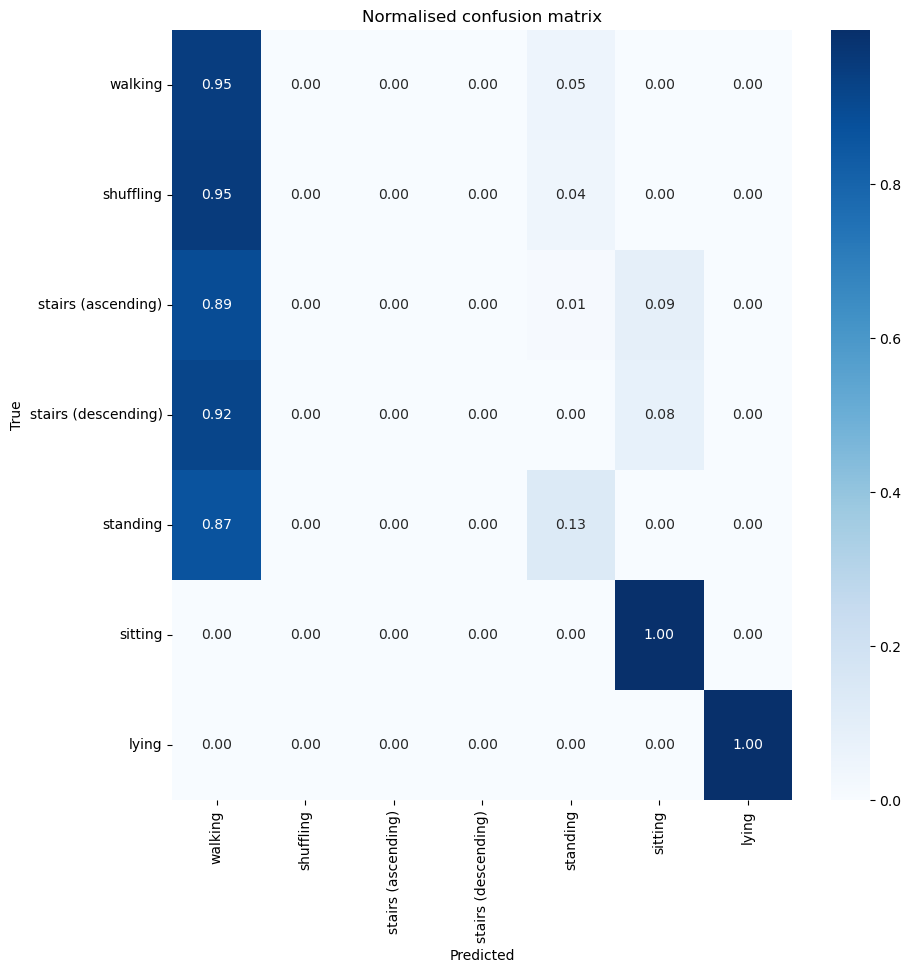

In [33]:
# Normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Normalised confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [34]:
# The performance of the model has improved, but it is still not great
# Let's try with a variery of window sizes to see if we can improve the performance

window_sizes = [10, 50, 100, 500, 1000]

best_alphas_list = []
train_scores_list = []
test_scores_list = []
y_test_pred_decoded_list = []

for window_size in window_sizes:
    X_train_buffered, y_train_buffered, X_val_buffered, y_val_buffered, X_test_buffered, y_test_buffered = prepare_buffered_data(window_size, X_train_scaled, y_train_encoded, X_val_scaled, y_val_encoded, X_test_scaled, y_test_encoded)
    
    alphas = np.logspace(-3, 3, 7)

    train_scores = []
    
    print(f"-------\nWindow size: {window_size}")

    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_buffered, y_train_buffered)
        train_scores.append(ridge.score(X_val_buffered, y_val_buffered))

    train_scores_list.append(train_scores)
    
    best_alpha = alphas[np.argmax(train_scores)]
    best_alphas_list.append(best_alpha)

    print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")

    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train_buffered, y_train_buffered)
    test_score = ridge.score(X_test_buffered, y_test_buffered)
    
    test_scores_list.append(test_score)

    print(f"Test score: {test_score}")

    y_test_pred_encoded = ridge.predict(X_test_buffered)
    y_test_pred_encoded = y_test_pred_encoded.reshape(-1, n_classes)
    y_test_pred_encoded = y_test_pred_encoded[:y_test_encoded.shape[0]]
    y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

    y_test_pred_decoded_list.append(y_test_pred_decoded)
    

Buffered train shape: (135765, 60), (135765, 70)
Buffered val shape: (33941, 60), (33941, 70)
Buffered test shape: (56255, 60), (56255, 70)
-------
Window size: 10
Best alpha: 10.0 with score: 0.03324899155604105
Test score: 0.2078670135044406
Buffered train shape: (27153, 300), (27153, 350)
Buffered val shape: (6789, 300), (6789, 350)
Buffered test shape: (11251, 300), (11251, 350)
-------
Window size: 50
Best alpha: 10.0 with score: 0.12474128356342835
Test score: 0.26925012229606704
Buffered train shape: (13577, 600), (13577, 700)
Buffered val shape: (3395, 600), (3395, 700)
Buffered test shape: (5626, 600), (5626, 700)
-------
Window size: 100
Best alpha: 10.0 with score: 0.12499161055140377
Test score: 0.2623335002978433
Buffered train shape: (2716, 3000), (2716, 3500)
Buffered val shape: (679, 3000), (679, 3500)
Buffered test shape: (1126, 3000), (1126, 3500)
-------
Window size: 500
Best alpha: 100.0 with score: 0.1069543914044447
Test score: 0.27332867926533266
Buffered train s

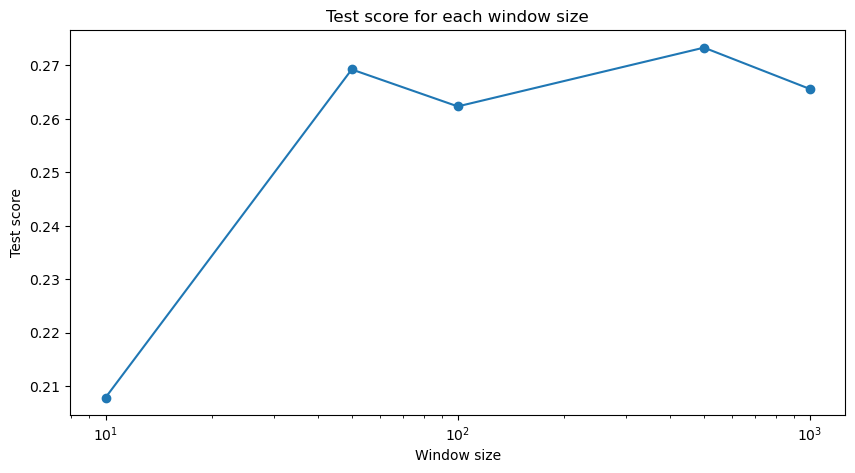

In [35]:
# Plot the test scores for each window size
plt.figure(figsize=(10, 5))
plt.plot(window_sizes, test_scores_list, marker='o')
plt.xlabel('Window size')
plt.ylabel('Test score')
plt.title('Test score for each window size')
plt.xscale('log')
plt.show()

In [36]:
# Print the classification report for each window size
for window_size, y_test_pred_decoded in zip(window_sizes, y_test_pred_decoded_list):
    print(f"Window size: {window_size}")
    print(classification_report(y_test_decoded, y_test_pred_decoded))
    print()
    

Window size: 10


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.69      0.95      0.80    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.50      0.13      0.21    141796
           7       0.98      1.00      0.99     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.71    562547
   macro avg       0.45      0.44      0.43    562547
weighted avg       0.64      0.71      0.64    562547


Window size: 50


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.72      0.97      0.83    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.75      0.21      0.33    141796
           7       1.00      1.00      1.00     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.74    562547
   macro avg       0.49      0.45      0.45    562547
weighted avg       0.72      0.74      0.68    562547


Window size: 100


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.72      0.97      0.82    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.72      0.21      0.33    141796
           7       1.00      1.00      1.00     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.74    562547
   macro avg       0.49      0.45      0.45    562547
weighted avg       0.71      0.74      0.68    562547


Window size: 500


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.70      0.99      0.82    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.86      0.11      0.20    141796
           7       0.99      0.99      0.99     43204
           8       1.00      0.99      1.00      8248

    accuracy                           0.73    562547
   macro avg       0.51      0.44      0.43    562547
weighted avg       0.74      0.73      0.65    562547


Window size: 1000


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.70      0.99      0.82    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.74      0.10      0.18    141796
           7       0.98      0.99      0.98     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.72    562547
   macro avg       0.49      0.44      0.42    562547
weighted avg       0.71      0.72      0.64    562547




C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


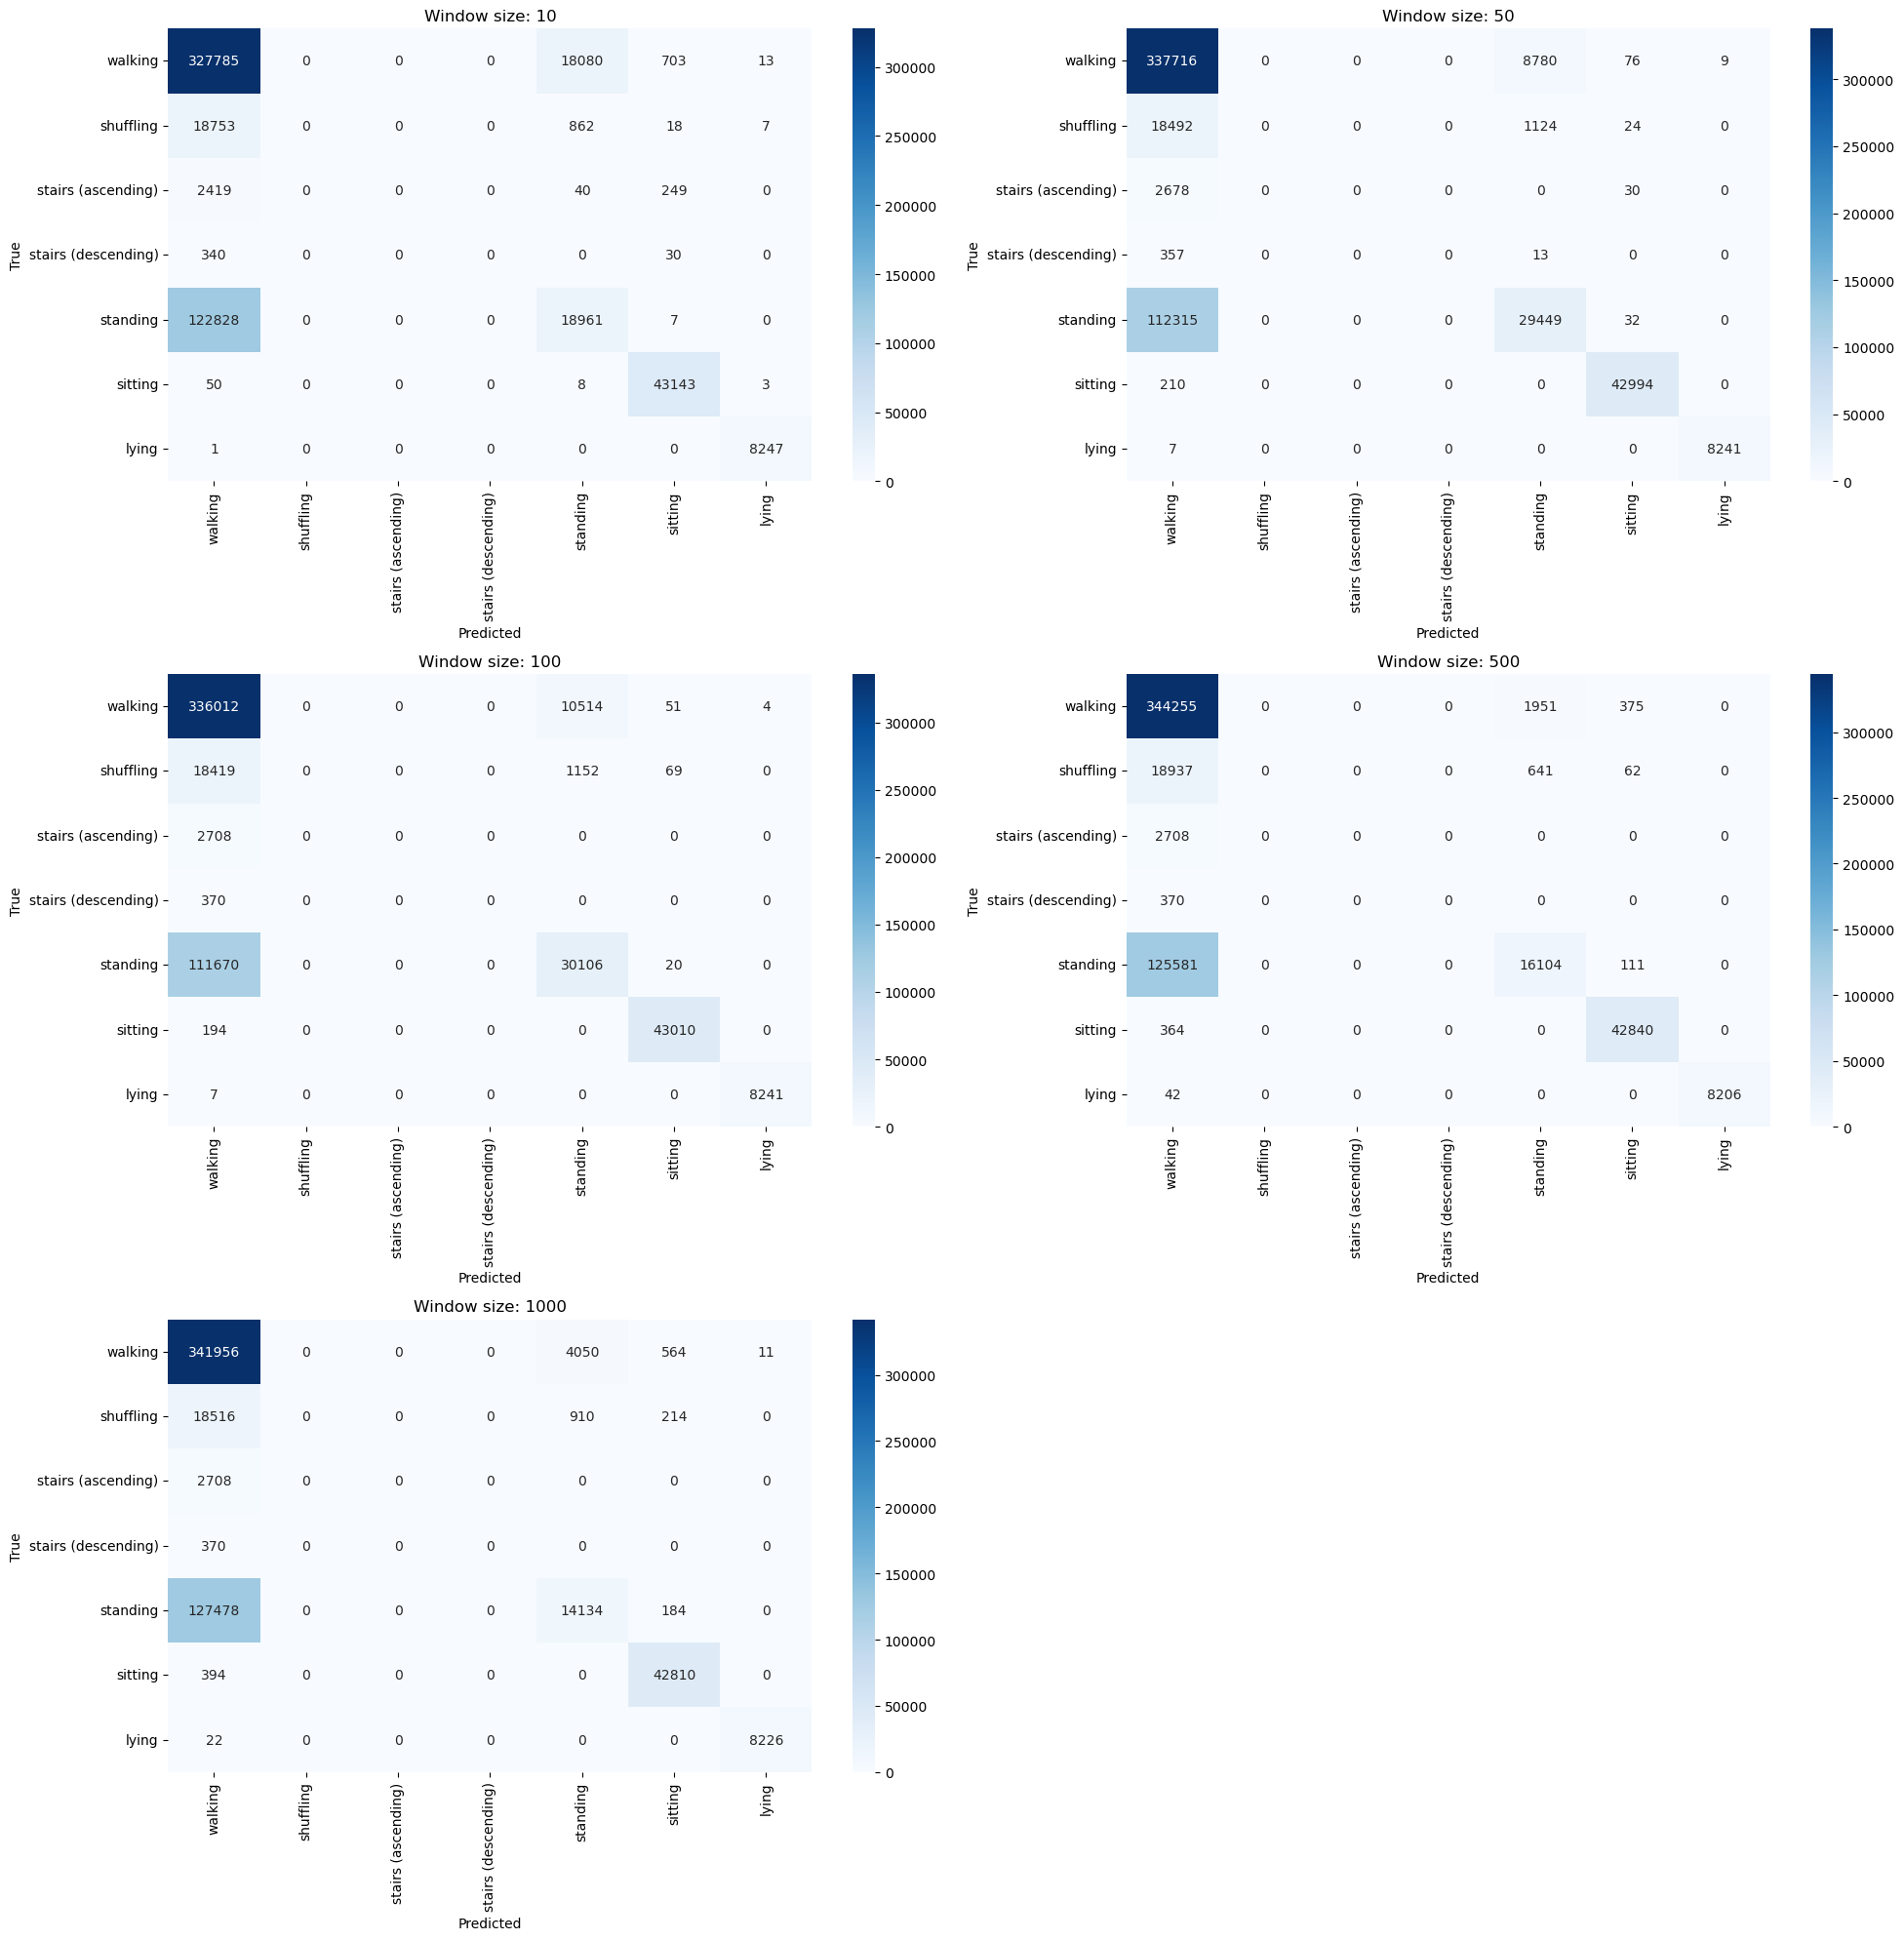

In [37]:
# Plot the confusion matrix for each window size
plt.figure(figsize=(20, 20))

for i, (window_size, y_test_pred_decoded) in enumerate(zip(window_sizes, y_test_pred_decoded_list)):
    conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

    plt.subplot(3, 2, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Window size: {window_size}')
    
plt.tight_layout()
plt.show()

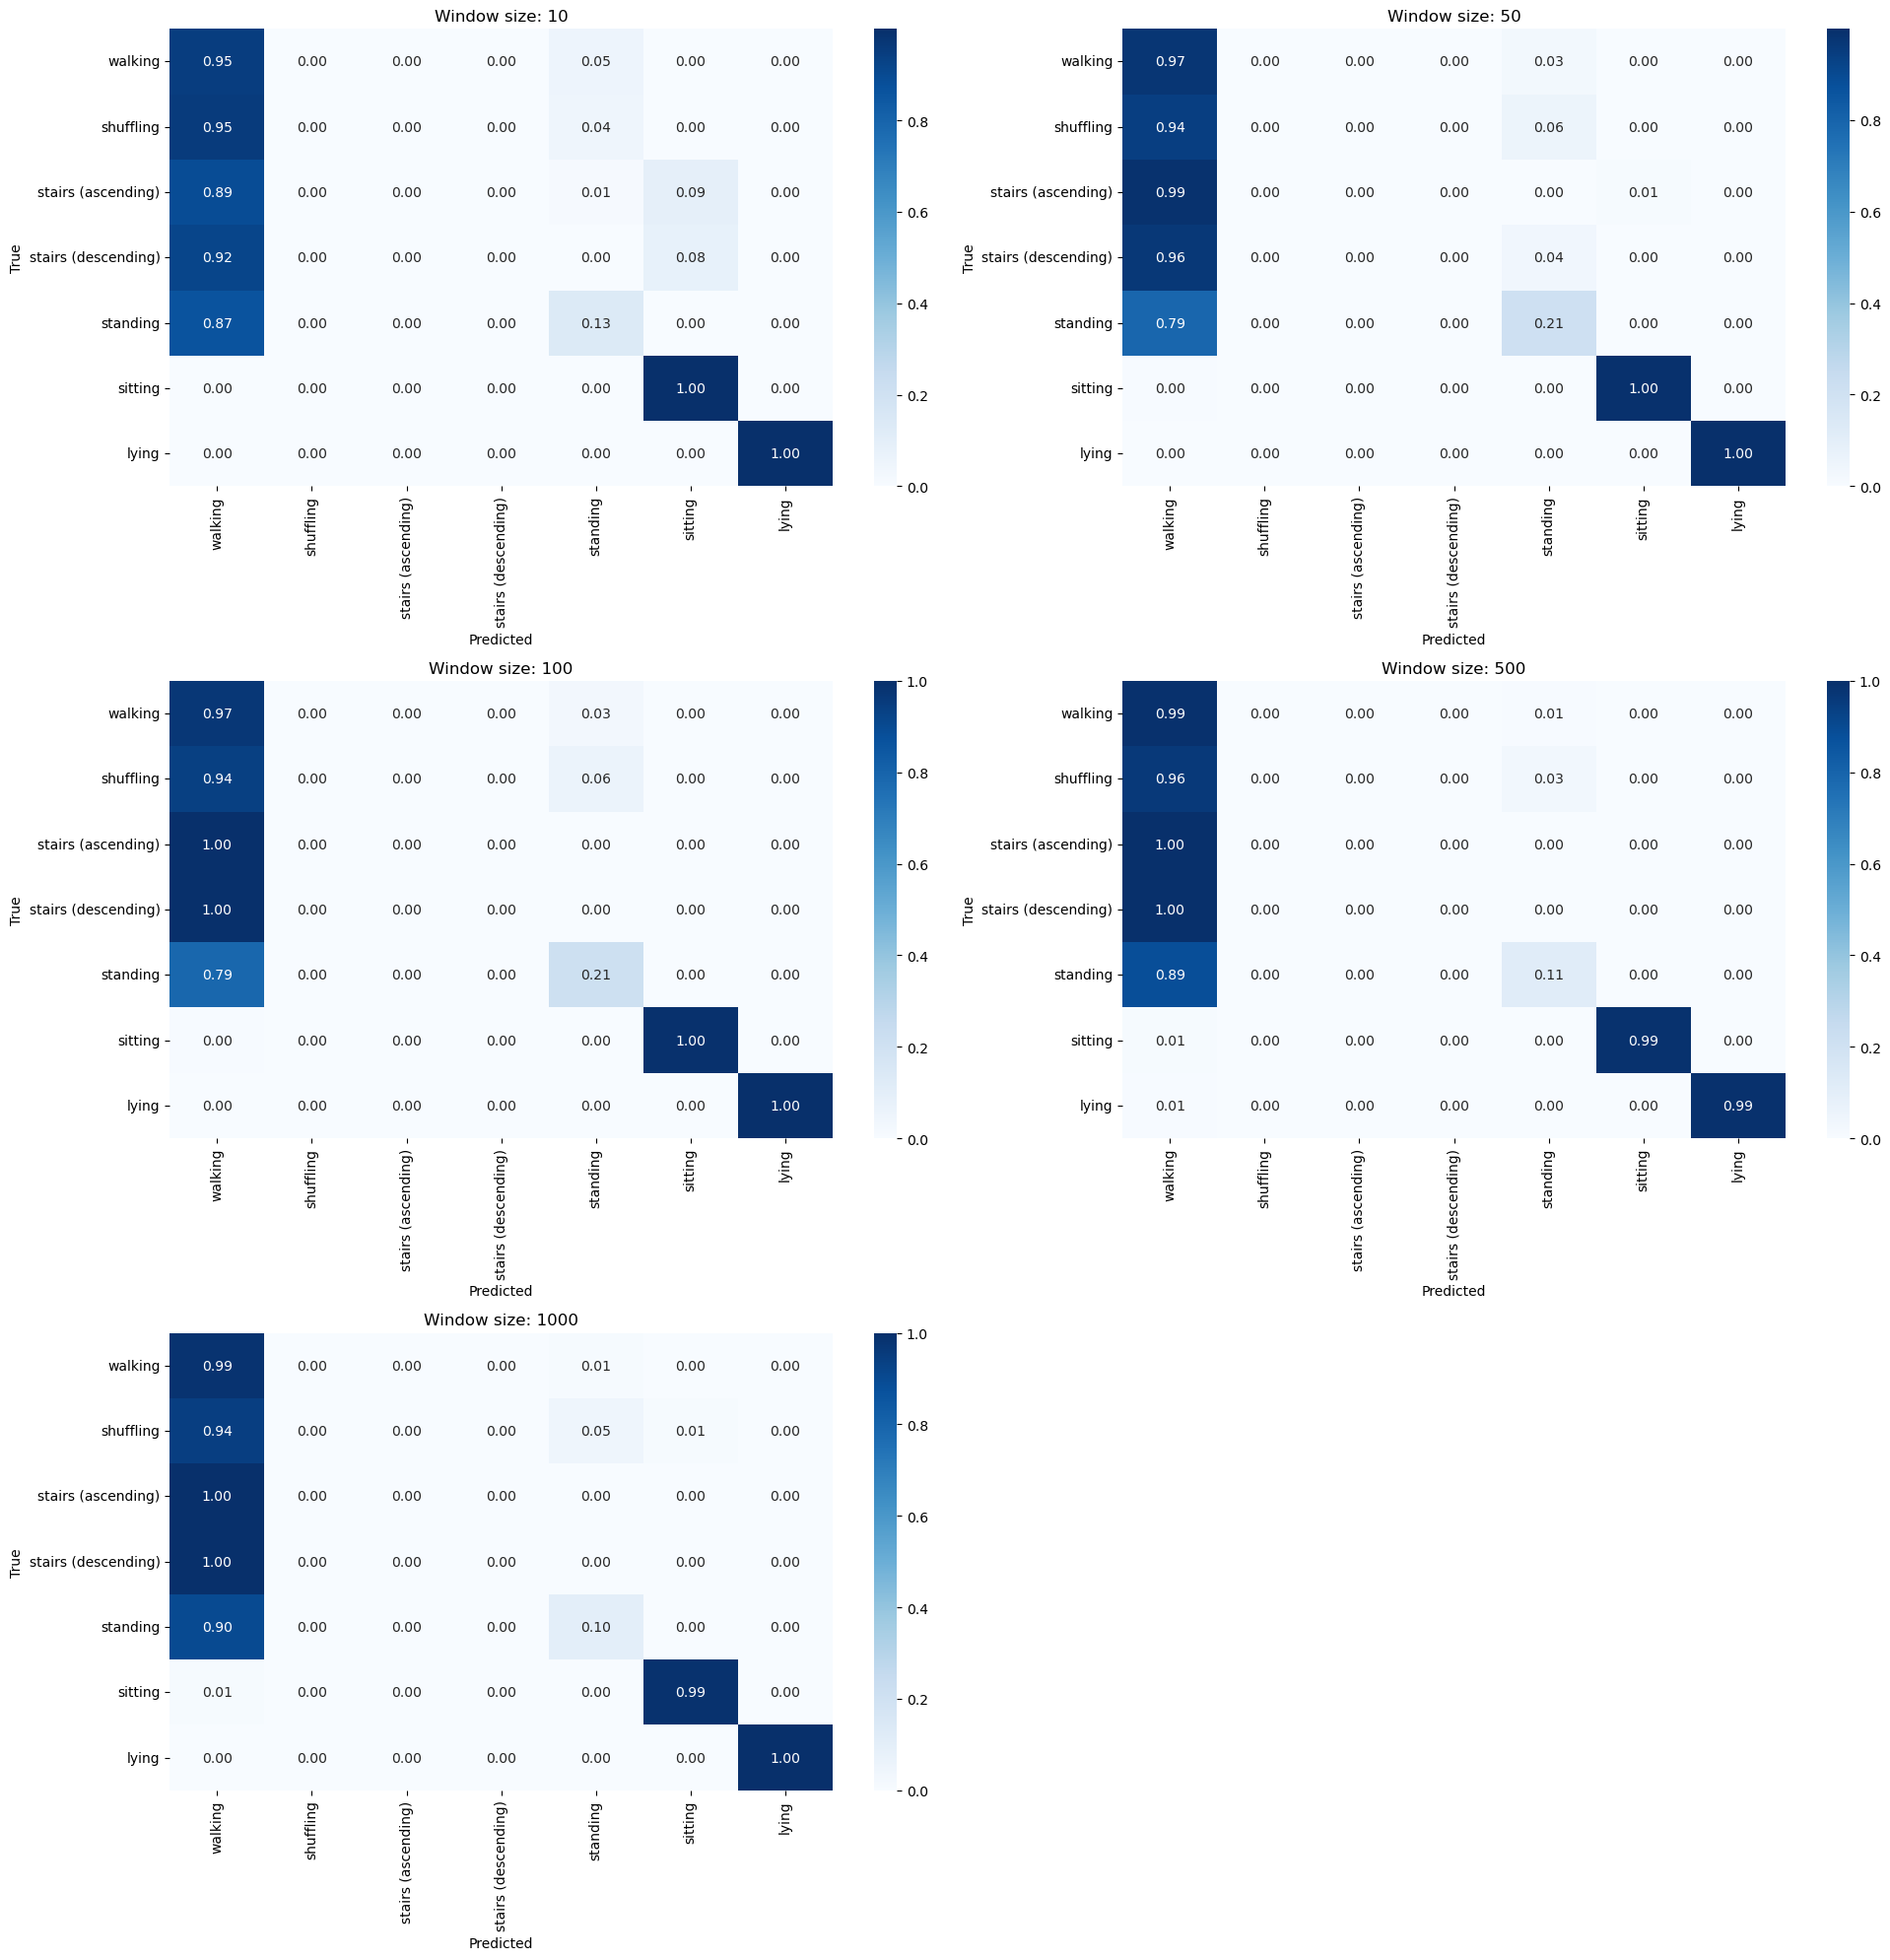

In [38]:
# Normalised confusion matrix for each window size

plt.figure(figsize=(20, 20))

for i, (window_size, y_test_pred_decoded) in enumerate(zip(window_sizes, y_test_pred_decoded_list)):
    conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.subplot(3, 2, i+1)
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title(f'Window size: {window_size}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
plt.tight_layout()
plt.show()

In [39]:
# Select the best window size and alpha
best_window_size = window_sizes[np.argmax(test_scores_list)]
best_alpha = best_alphas_list[np.argmax(test_scores_list)]

print(f"Best window size: {best_window_size}, Best alpha: {best_alpha}")

Best window size: 500, Best alpha: 100.0


In [41]:
# This process has used a lot of memory, so let's call the garbage collector to free up some memory
import gc
gc.collect()

86646

In [42]:
# Now we can train the model on the best window size and alpha
X_train_buffered, y_train_buffered, X_val_buffered, y_val_buffered, X_test_buffered, y_test_buffered = prepare_buffered_data(best_window_size, X_train_scaled, y_train_encoded, X_val_scaled, y_val_encoded, X_test_scaled, y_test_encoded)

ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_buffered, y_train_buffered)
test_score = ridge.score(X_test_buffered, y_test_buffered)

print(f"Test score: {test_score}")

Buffered train shape: (2716, 3000), (2716, 3500)
Buffered val shape: (679, 3000), (679, 3500)
Buffered test shape: (1126, 3000), (1126, 3500)
Test score: 0.27332867926533266


In [43]:
# Evaluate the model using the decoded labels
y_test_pred_encoded = ridge.predict(X_test_buffered)
y_test_pred_encoded = y_test_pred_encoded.reshape(-1, n_classes)
y_test_pred_encoded = y_test_pred_encoded[:y_test_encoded.shape[0]]
y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

print(classification_report(y_test_decoded, y_test_pred_decoded))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.70      0.99      0.82    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.86      0.11      0.20    141796
           7       0.99      0.99      0.99     43204
           8       1.00      0.99      1.00      8248

    accuracy                           0.73    562547
   macro avg       0.51      0.44      0.43    562547
weighted avg       0.74      0.73      0.65    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


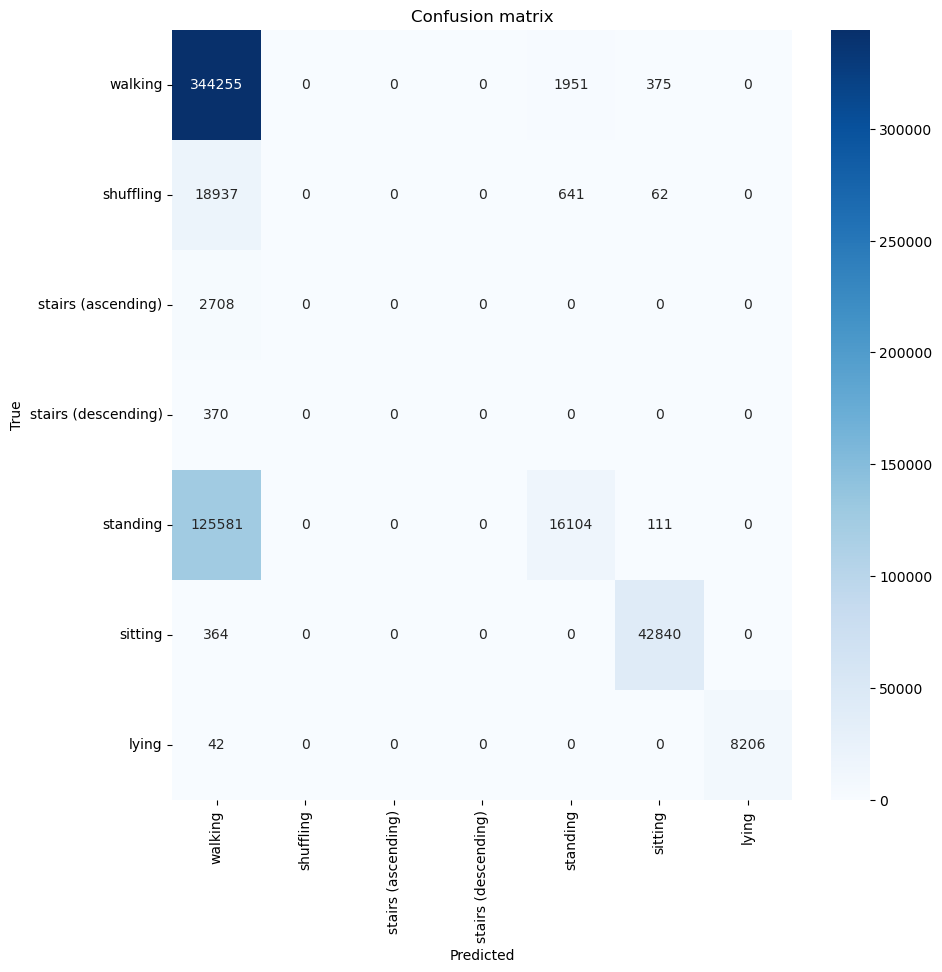

In [44]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

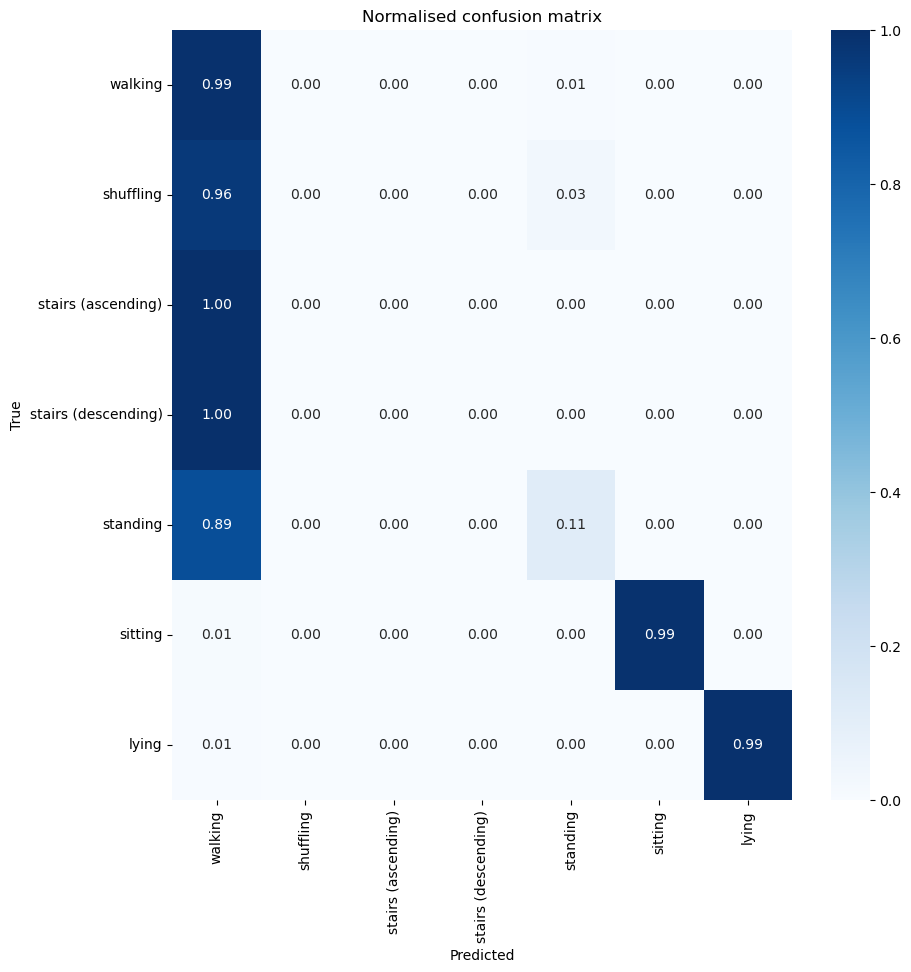

In [45]:
# Normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Normalised confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [49]:
# For the sake of completeness, let's test the same windows, but with the class weights
best_alphas_list = []
train_scores_list = []
test_scores_list = []
y_test_pred_decoded_list = []

for window_size in window_sizes:
    X_train_buffered, y_train_buffered, X_val_buffered, y_val_buffered, X_test_buffered, y_test_buffered = prepare_buffered_data(window_size, X_train_scaled, y_train_encoded, X_val_scaled, y_val_encoded, X_test_scaled, y_test_encoded)

    # The class weights are in the shape (n_samples,) but our data is now in the shape (n_samples//window_size, n_features*window_size) so we need to reshape the class weights to match the shape of the data

    train_weights_buffered = np.array([train_weights[i] for i in range(0, len(train_weights), window_size)])
    val_weights_buffered = np.array([val_weights[i] for i in range(0, len(val_weights), window_size)])
    test_weights_buffered = np.array([test_weights[i] for i in range(0, len(test_weights), window_size)])
    
    alphas = np.logspace(-3, 3, 7)

    train_scores = []
    
    print(f"-------\nWindow size: {window_size}")

    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_buffered, y_train_buffered, sample_weight=train_weights_buffered)
        train_scores.append(ridge.score(X_val_buffered, y_val_buffered, sample_weight=val_weights_buffered))

    train_scores_list.append(train_scores)
    
    best_alpha = alphas[np.argmax(train_scores)]
    best_alphas_list.append(best_alpha)

    print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")

    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train_buffered, y_train_buffered, sample_weight=train_weights_buffered)
    test_score = ridge.score(X_test_buffered, y_test_buffered, sample_weight=test_weights_buffered)
    
    test_scores_list.append(test_score)

    print(f"Test score: {test_score}")

    y_test_pred_encoded = ridge.predict(X_test_buffered)
    y_test_pred_encoded = y_test_pred_encoded.reshape(-1, n_classes)
    y_test_pred_encoded = y_test_pred_encoded[:y_test_encoded.shape[0]]
    y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

    y_test_pred_decoded_list.append(y_test_pred_decoded)

Buffered train shape: (135765, 60), (135765, 70)
Buffered val shape: (33941, 60), (33941, 70)
Buffered test shape: (56255, 60), (56255, 70)
-------
Window size: 10
Best alpha: 100.0 with score: 0.04577077534860377
Test score: -0.09189794651674922
Buffered train shape: (27153, 300), (27153, 350)
Buffered val shape: (6789, 300), (6789, 350)
Buffered test shape: (11251, 300), (11251, 350)
-------
Window size: 50
Best alpha: 100.0 with score: 0.08798992195467417
Test score: 0.01746531778454315
Buffered train shape: (13577, 600), (13577, 700)
Buffered val shape: (3395, 600), (3395, 700)
Buffered test shape: (5626, 600), (5626, 700)
-------
Window size: 100
Best alpha: 100.0 with score: 0.09453905405675676
Test score: 0.009893138413778504
Buffered train shape: (2716, 3000), (2716, 3500)
Buffered val shape: (679, 3000), (679, 3500)
Buffered test shape: (1126, 3000), (1126, 3500)
-------
Window size: 500
Best alpha: 10.0 with score: 0.12775880811054371
Test score: -0.1758860709841239
Buffered 

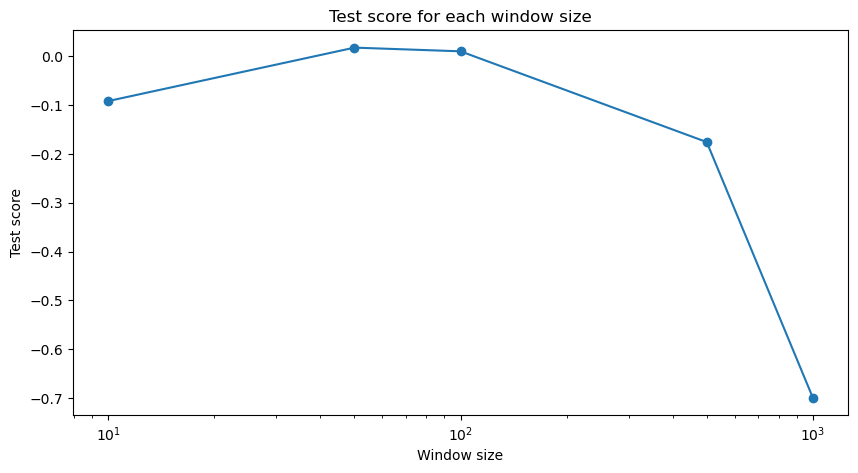

In [50]:
# Plot the test scores for each window size
plt.figure(figsize=(10, 5))
plt.plot(window_sizes, test_scores_list, marker='o')
plt.xlabel('Window size')
plt.ylabel('Test score')
plt.title('Test score for each window size')
plt.xscale('log')
plt.show()

In [51]:
# Print the classification report for each window size
for window_size, y_test_pred_decoded in zip(window_sizes, y_test_pred_decoded_list):
    print(f"Window size: {window_size}")
    print(classification_report(y_test_decoded, y_test_pred_decoded))
    print()    

Window size: 10
              precision    recall  f1-score   support

           1       1.00      0.00      0.00    346581
           3       0.02      0.04      0.03     19640
           4       0.01      0.00      0.00      2708
           5       0.00      0.73      0.00       370
           6       0.40      0.53      0.46    141796
           7       0.85      1.00      0.92     43204
           8       0.75      1.00      0.86      8248

    accuracy                           0.23    562547
   macro avg       0.43      0.47      0.32    562547
weighted avg       0.79      0.23      0.20    562547


Window size: 50
              precision    recall  f1-score   support

           1       0.90      0.10      0.18    346581
           3       0.03      0.03      0.03     19640
           4       0.05      0.14      0.08      2708
           5       0.00      0.45      0.00       370
           6       0.38      0.79      0.52    141796
           7       0.99      1.00      0.99  

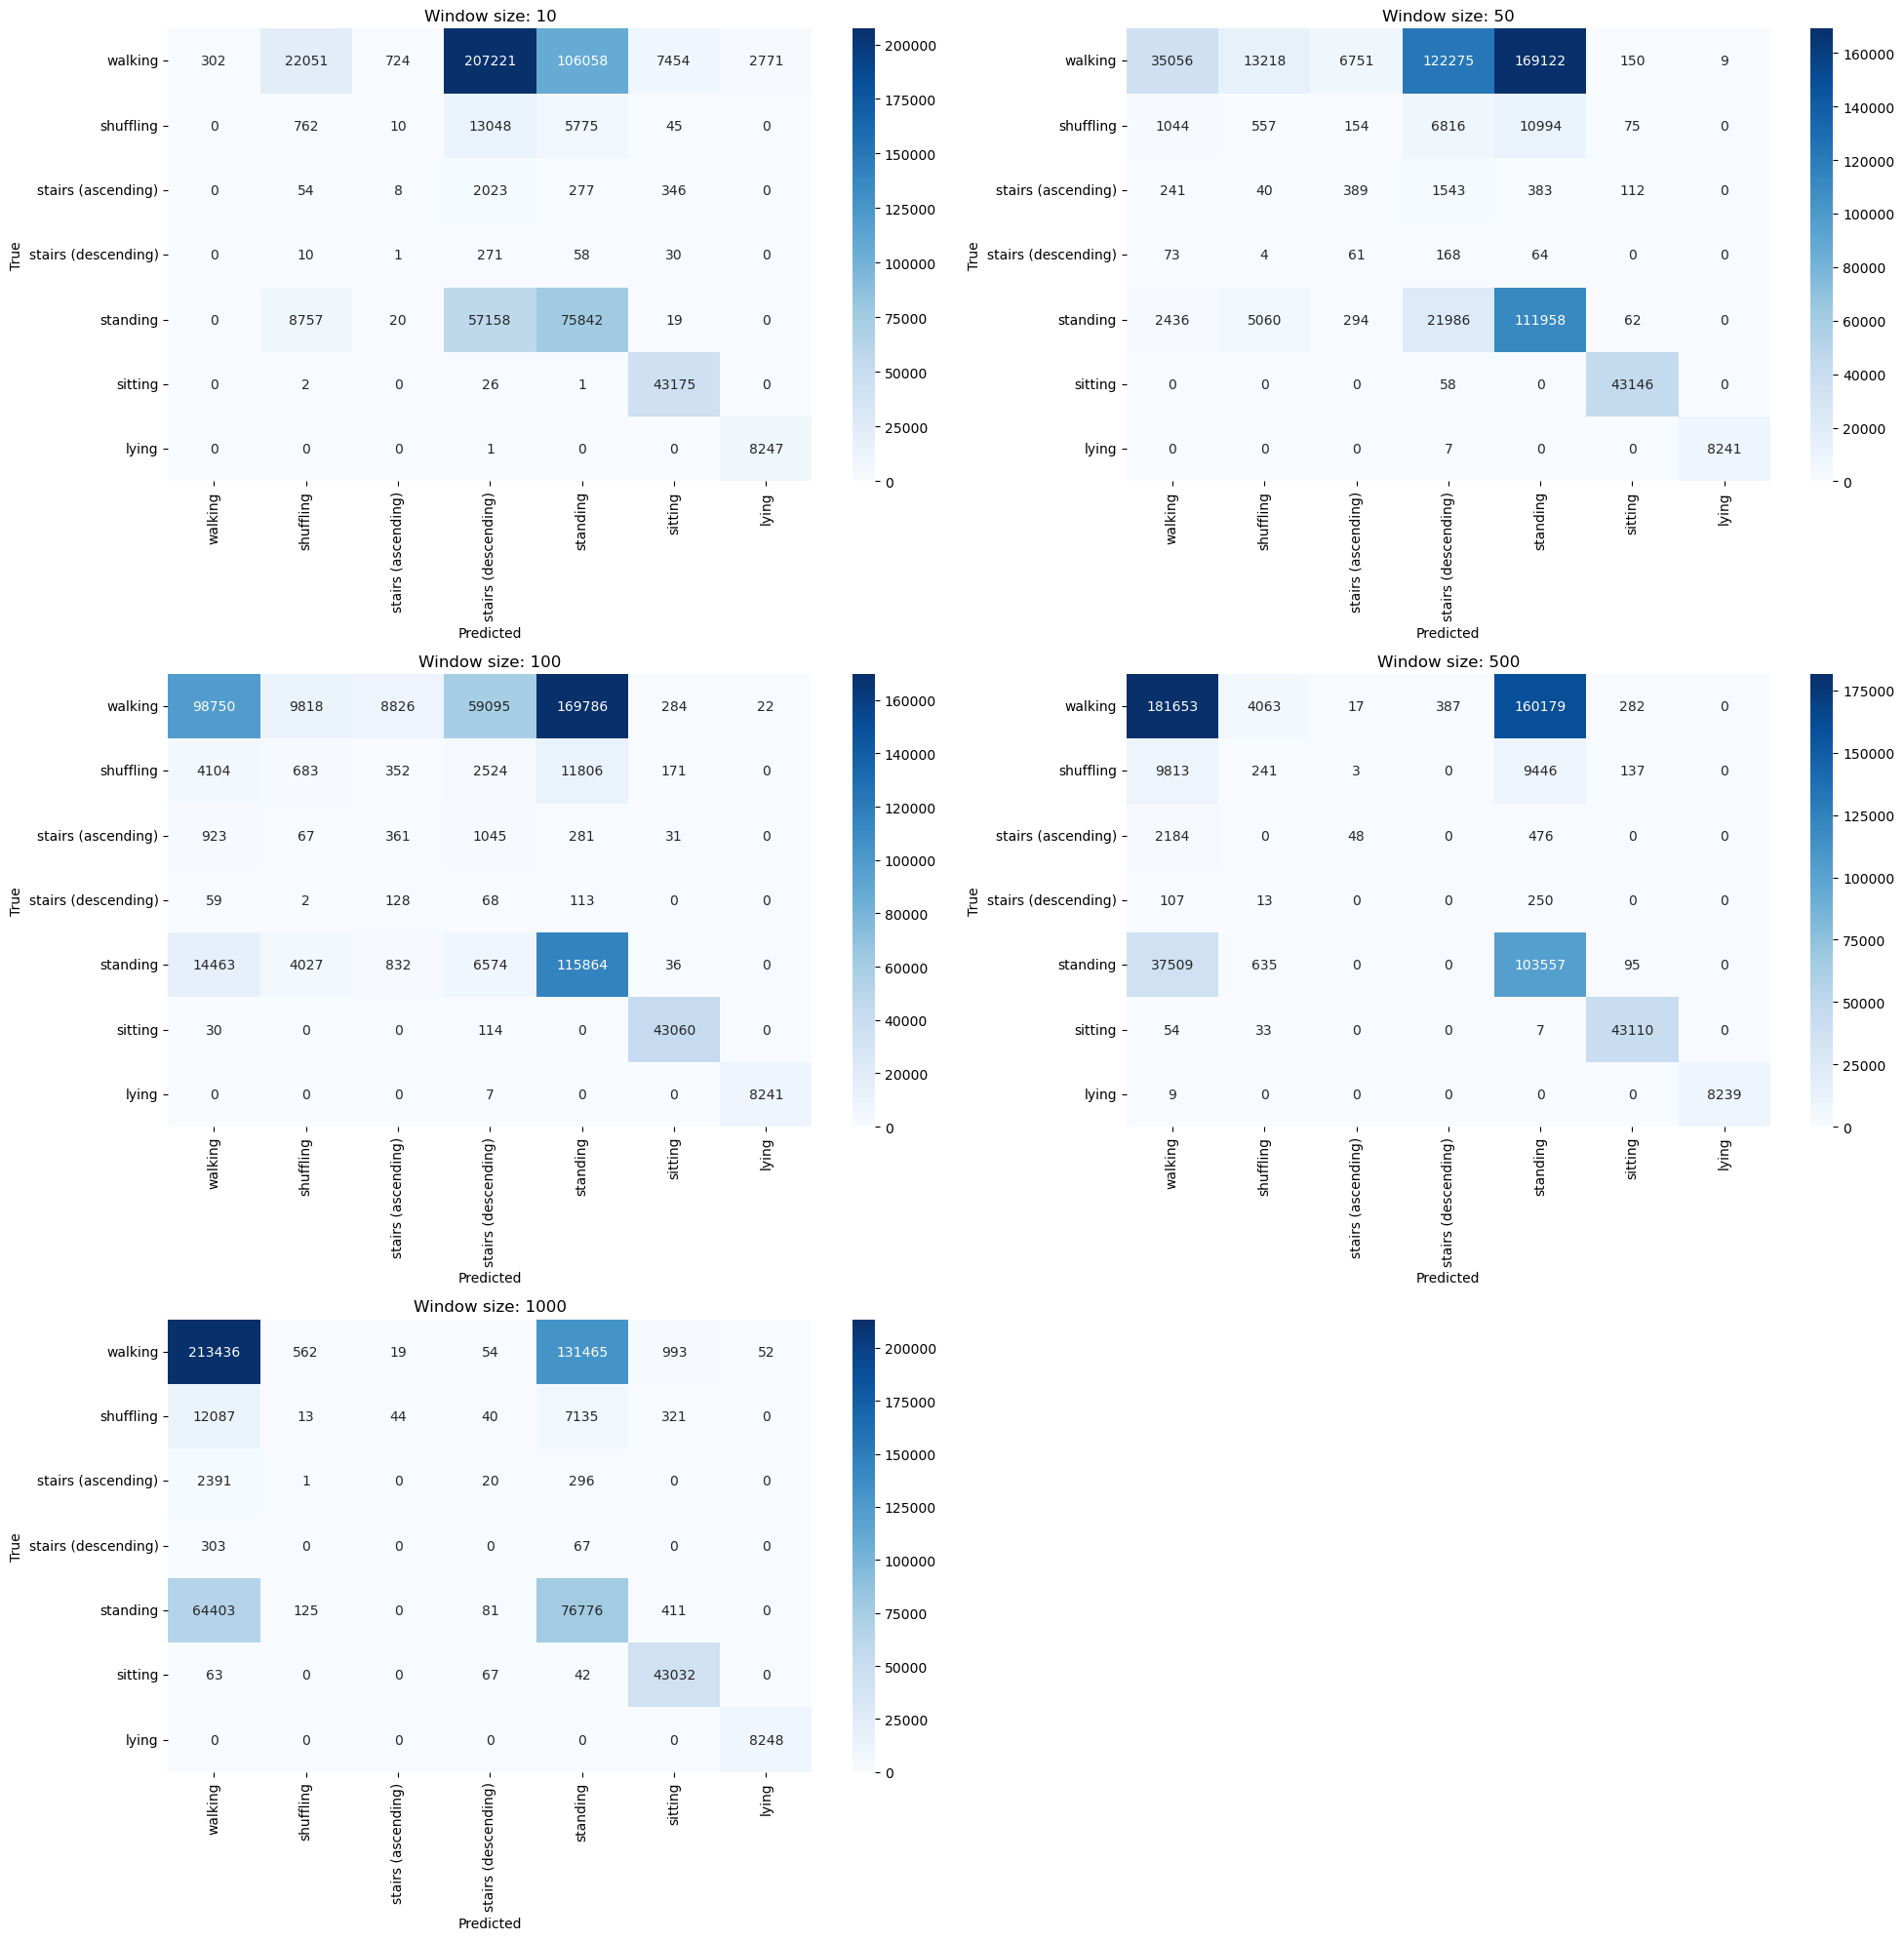

In [52]:
# Plot the confusion matrix for each window size
plt.figure(figsize=(20, 20))

for i, (window_size, y_test_pred_decoded) in enumerate(zip(window_sizes, y_test_pred_decoded_list)):
    conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

    plt.subplot(3, 2, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Window size: {window_size}')
    
plt.tight_layout()
plt.show()

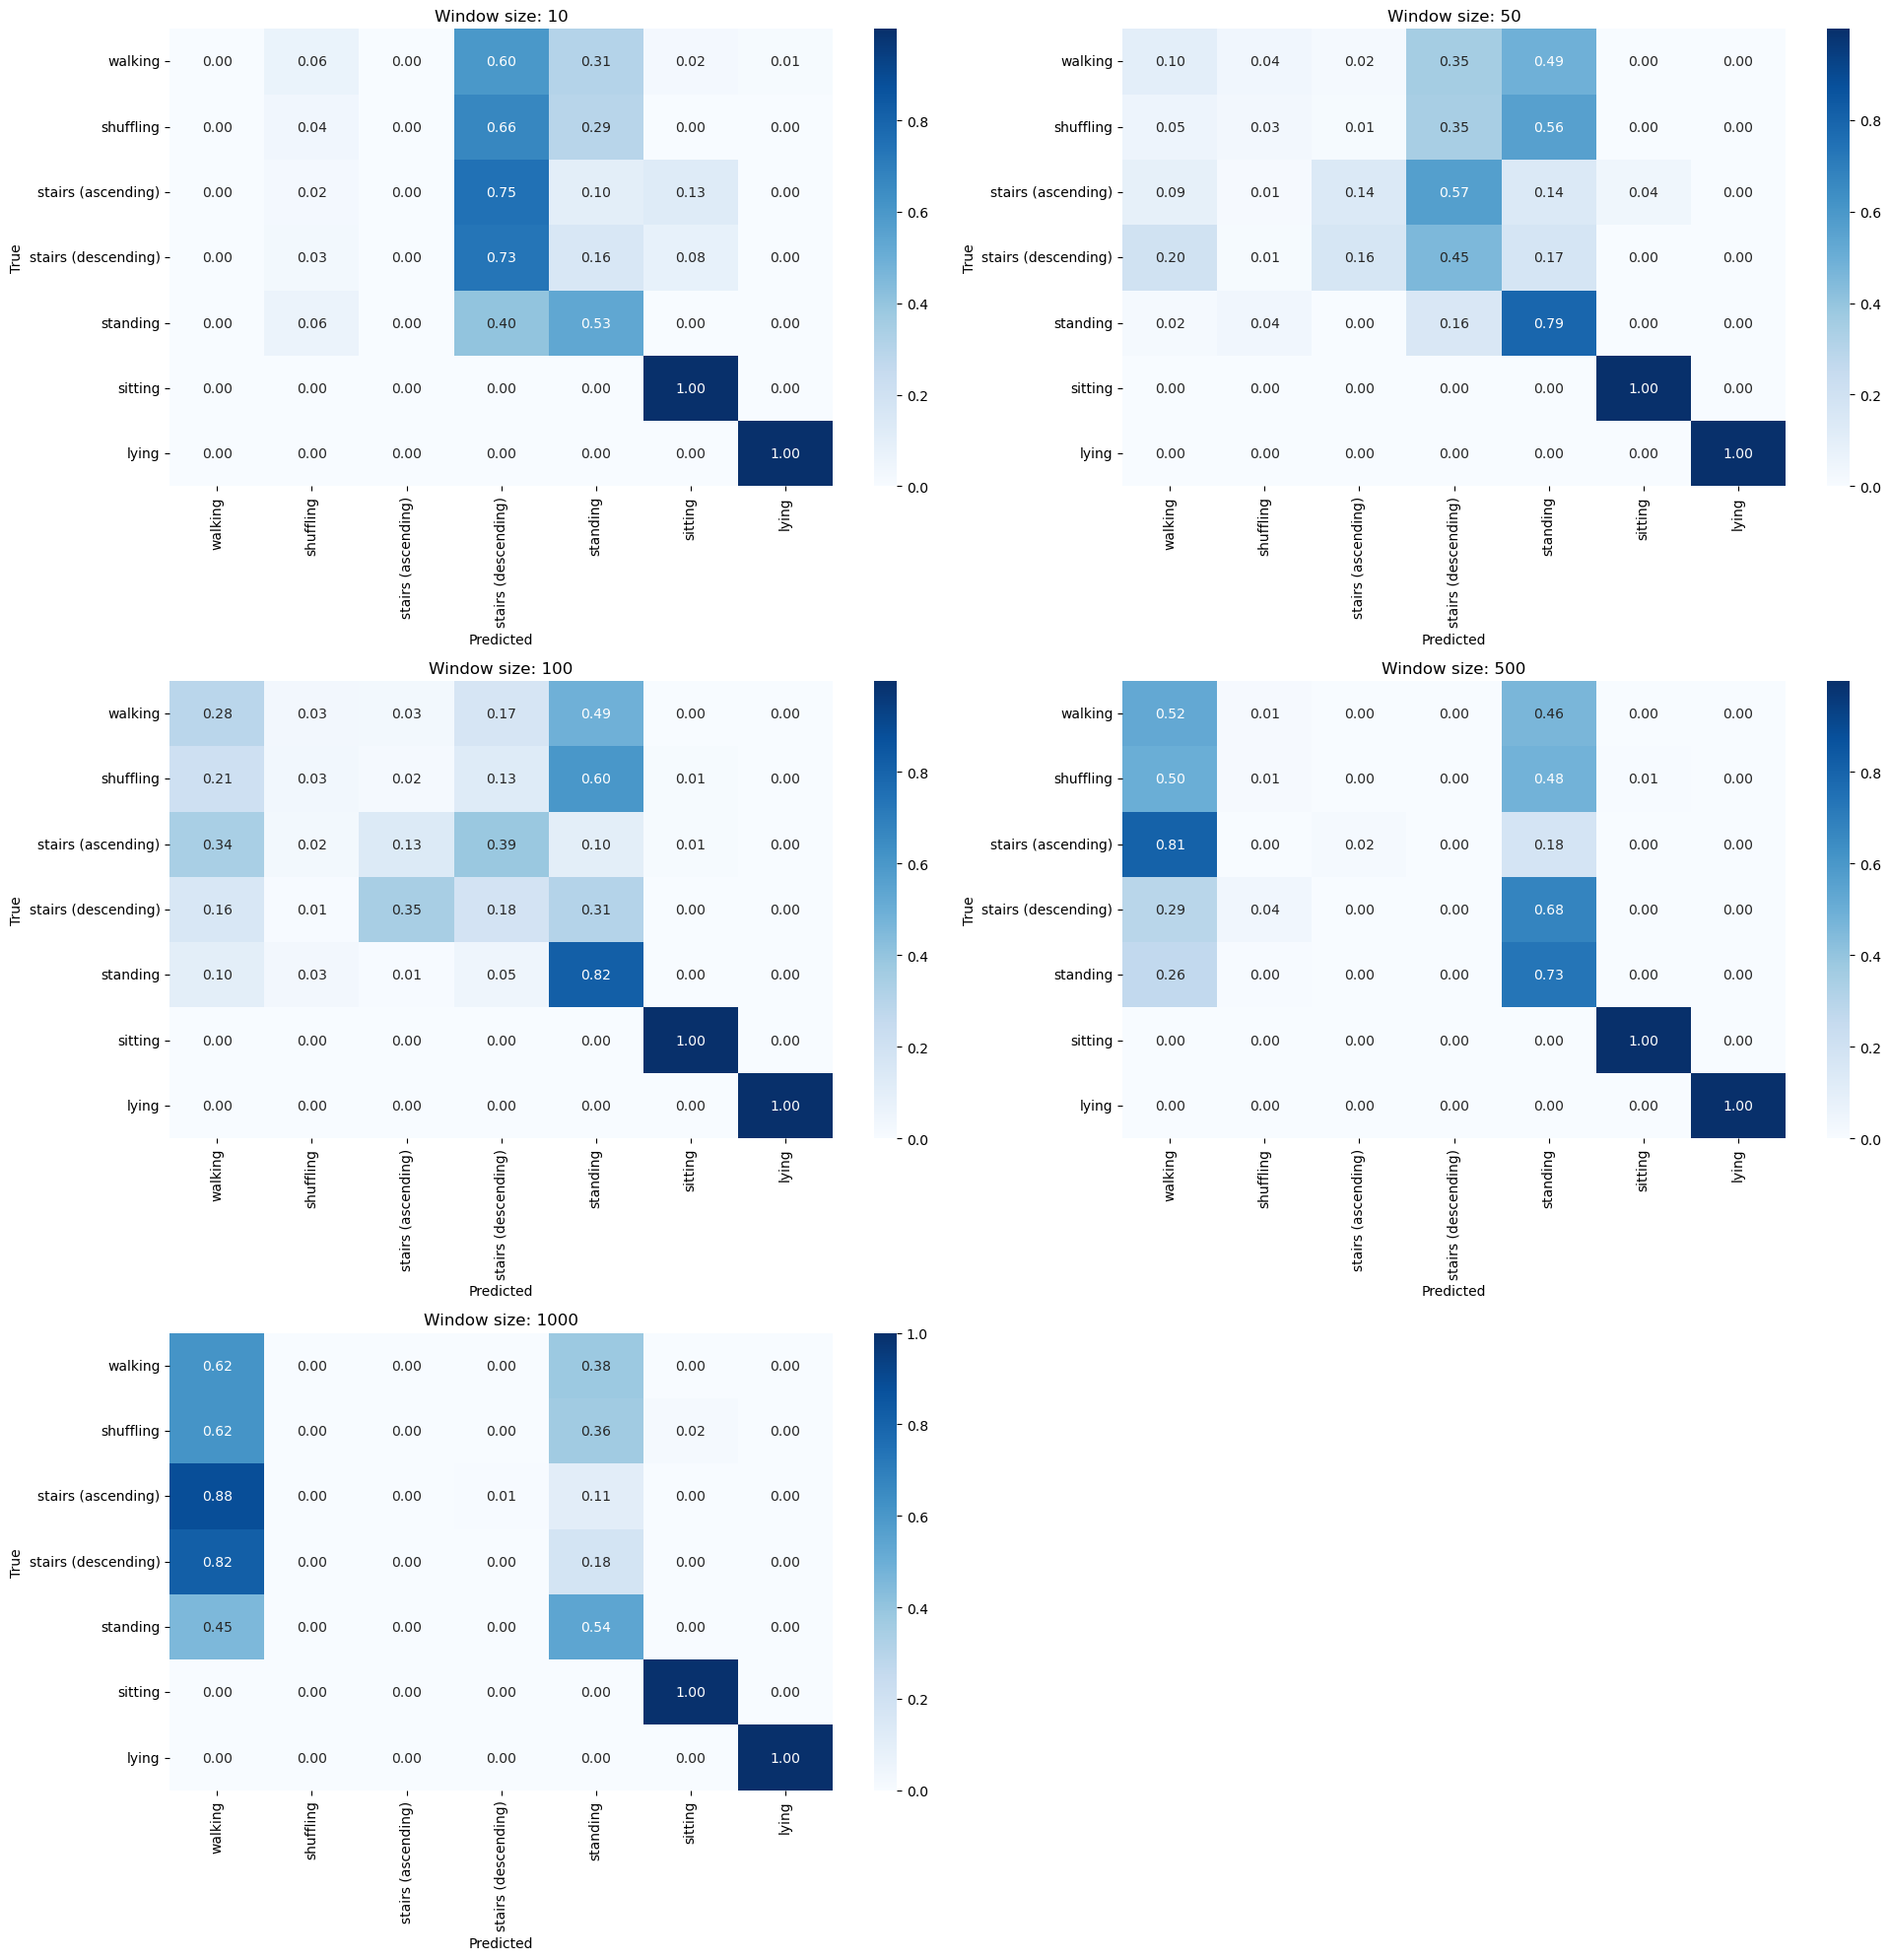

In [53]:
# Normalised confusion matrix for each window size

plt.figure(figsize=(20, 20))

for i, (window_size, y_test_pred_decoded) in enumerate(zip(window_sizes, y_test_pred_decoded_list)):
    conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.subplot(3, 2, i+1)
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title(f'Window size: {window_size}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
plt.tight_layout()
plt.show()


In [54]:
# Select the best window size and alpha
best_window_size = window_sizes[np.argmax(test_scores_list)]
best_alpha = best_alphas_list[np.argmax(test_scores_list)]

print(f"Best window size: {best_window_size}, Best alpha: {best_alpha}")

Best window size: 50, Best alpha: 100.0


In [55]:
gc.collect()

87154

In [56]:
# Now we can train the model on the best window size and alpha
X_train_buffered, y_train_buffered, X_val_buffered, y_val_buffered, X_test_buffered, y_test_buffered = prepare_buffered_data(best_window_size, X_train_scaled, y_train_encoded, X_val_scaled, y_val_encoded, X_test_scaled, y_test_encoded)

train_weights_buffered = np.array([train_weights[i] for i in range(0, len(train_weights), best_window_size)])
val_weights_buffered = np.array([val_weights[i] for i in range(0, len(val_weights), best_window_size)])
test_weights_buffered = np.array([test_weights[i] for i in range(0, len(test_weights), best_window_size)])

ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_buffered, y_train_buffered, sample_weight=train_weights_buffered)
test_score = ridge.score(X_test_buffered, y_test_buffered, sample_weight=test_weights_buffered)

print(f"Test score: {test_score}")

Buffered train shape: (27153, 300), (27153, 350)
Buffered val shape: (6789, 300), (6789, 350)
Buffered test shape: (11251, 300), (11251, 350)
Test score: 0.01746531778454315


In [57]:
# Evaluate the model using the decoded labels
y_test_pred_encoded = ridge.predict(X_test_buffered)

n_classes = y_train_encoded.shape[1]

y_test_pred_encoded = y_test_pred_encoded.reshape(-1, n_classes)
y_test_pred_encoded = y_test_pred_encoded[:y_test_encoded.shape[0]]
y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

print(classification_report(y_test_decoded, y_test_pred_decoded))

              precision    recall  f1-score   support

           1       0.90      0.10      0.18    346581
           3       0.03      0.03      0.03     19640
           4       0.05      0.14      0.08      2708
           5       0.00      0.45      0.00       370
           6       0.38      0.79      0.52    141796
           7       0.99      1.00      0.99     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.35    562547
   macro avg       0.48      0.50      0.40    562547
weighted avg       0.74      0.35      0.33    562547



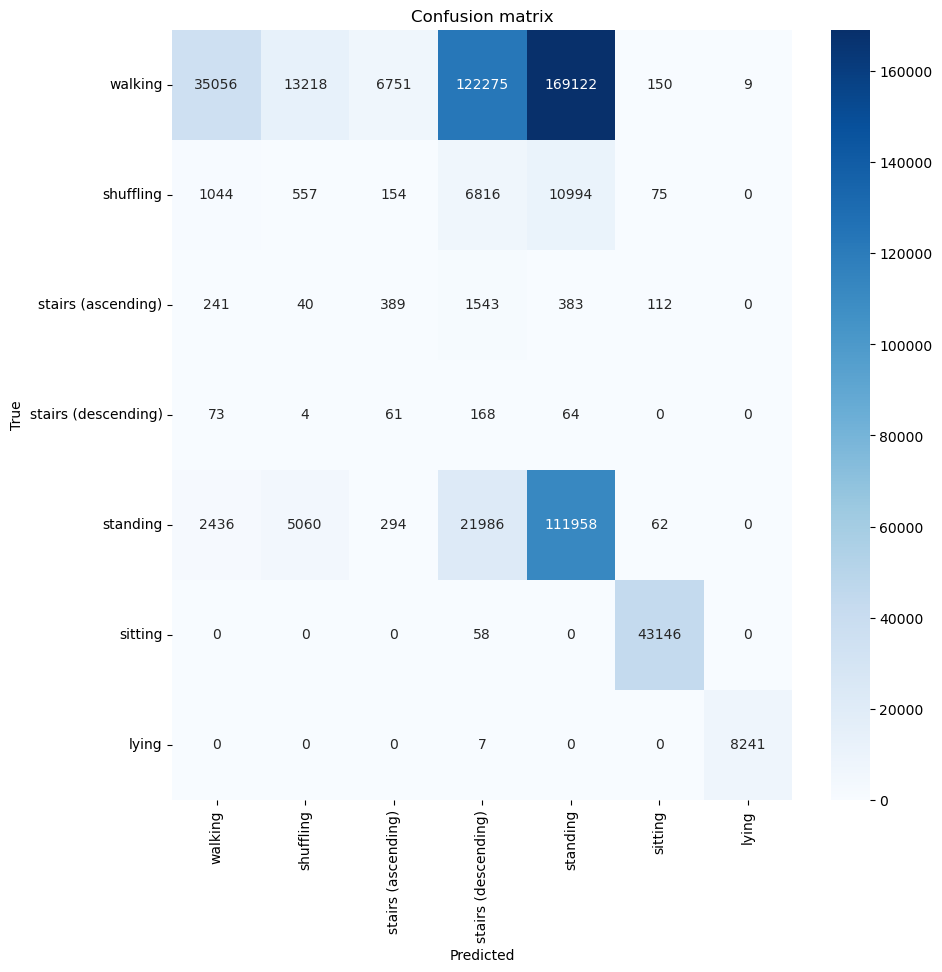

In [58]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

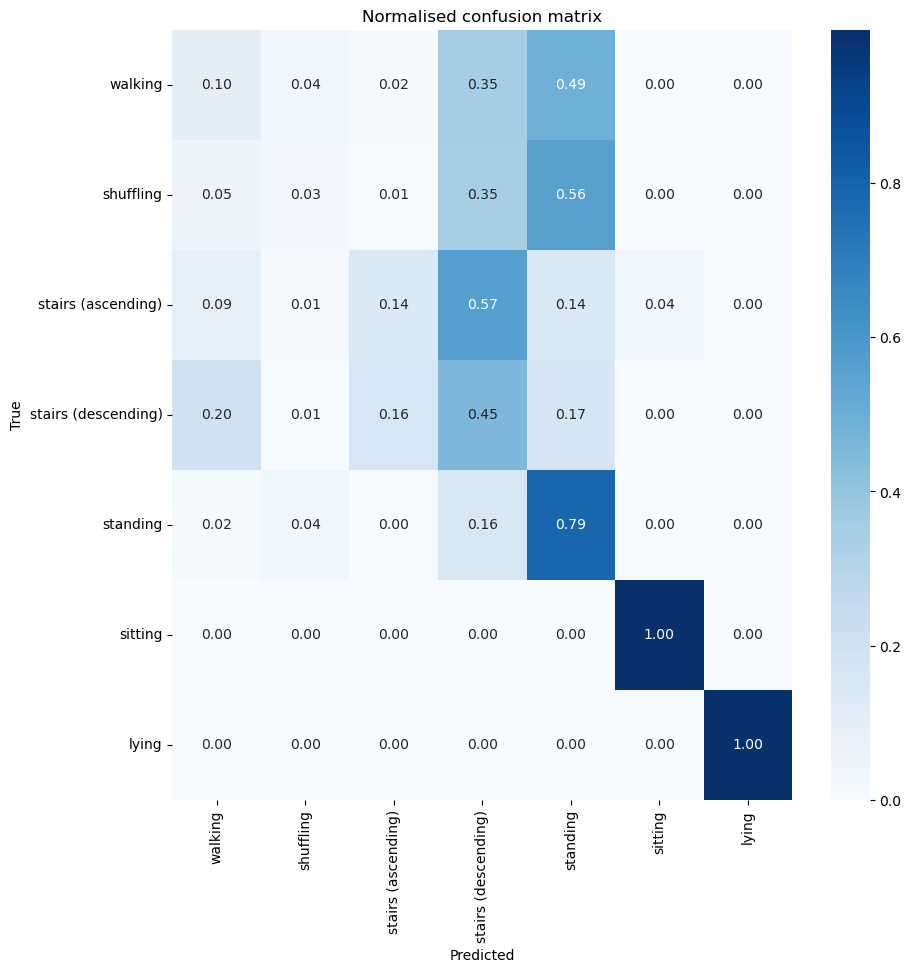

In [59]:
# Normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Normalised confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [59]:
# These scores aren't great. The best scores seem to have come from using a window size of 500 and no class weights

In [60]:
# Next, we will try using an exponential moving average to smooth the data before training the model
# This will allow the model to learn from the smoothed data, which may improve the performance

def prepare_smoothed_data(alpha, x_train, y_train, x_val, y_val, x_test, y_test):
    temp_x_train = x_train.copy()
    temp_y_train = y_train.copy()
    temp_x_val = x_val.copy()
    temp_y_val = y_val.copy()
    temp_x_test = x_test.copy()
    temp_y_test = y_test.copy()
    
    # For each feature, we will apply the exponential moving average
    # The formula for the exponential moving average is: S_t = alpha * X_t + (1 - alpha) * S_{t-1}
    # Where S_t is the smoothed value, X_t is the original value, and alpha is the smoothing factor
    # Note that the first value of the smoothed data is the same as the original data
    
    for dataset in [temp_x_train, temp_x_val, temp_x_test]:
        for i in range(dataset.shape[1]):
            dataset[:, i] = alpha * dataset[:, i] + (1 - alpha) * np.roll(dataset[:, i], 1)
            
    X_train_smoothed = temp_x_train
    X_val_smoothed = temp_x_val
    X_test_smoothed = temp_x_test
    
    print(f"Smoothed train shape: {X_train_smoothed.shape}, {y_train.shape}")
    print(f"Smoothed val shape: {X_val_smoothed.shape}, {y_val.shape}")
    print(f"Smoothed test shape: {X_test_smoothed.shape}, {y_test.shape}")
    
    return X_train_smoothed, y_train, X_val_smoothed, y_val, X_test_smoothed, y_test

alpha = 0.9

X_train_smoothed, y_train_smoothed, X_val_smoothed, y_val_smoothed, X_test_smoothed, y_test_smoothed = prepare_smoothed_data(alpha, X_train_scaled, y_train_encoded, X_val_scaled, y_val_encoded, X_test_scaled, y_test_encoded)

Smoothed train shape: (1357646, 6), (1357646, 7)
Smoothed val shape: (339404, 6), (339404, 7)
Smoothed test shape: (562547, 6), (562547, 7)


In [61]:
# Now we can train the ridge regression model on the smoothed data
ridge_alphas = np.logspace(-3, 3, 7)

train_scores = []

for alpha in ridge_alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_smoothed, y_train_smoothed)
    train_scores.append(ridge.score(X_val_smoothed, y_val_smoothed))
    
best_alpha = ridge_alphas[np.argmax(train_scores)]

print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")

ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_smoothed, y_train_smoothed)
test_score = ridge.score(X_test_smoothed, y_test_smoothed)

print(f"Test score: {test_score}")

Best alpha: 1000.0 with score: -0.1321504436630057
Test score: 0.08268986981175093


In [62]:
# Evaluate the model using the decoded labels
y_test_pred_encoded = ridge.predict(X_test_smoothed)
y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

print(classification_report(y_test_decoded, y_test_pred_decoded))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.73      1.00      0.84     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.68      0.56    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


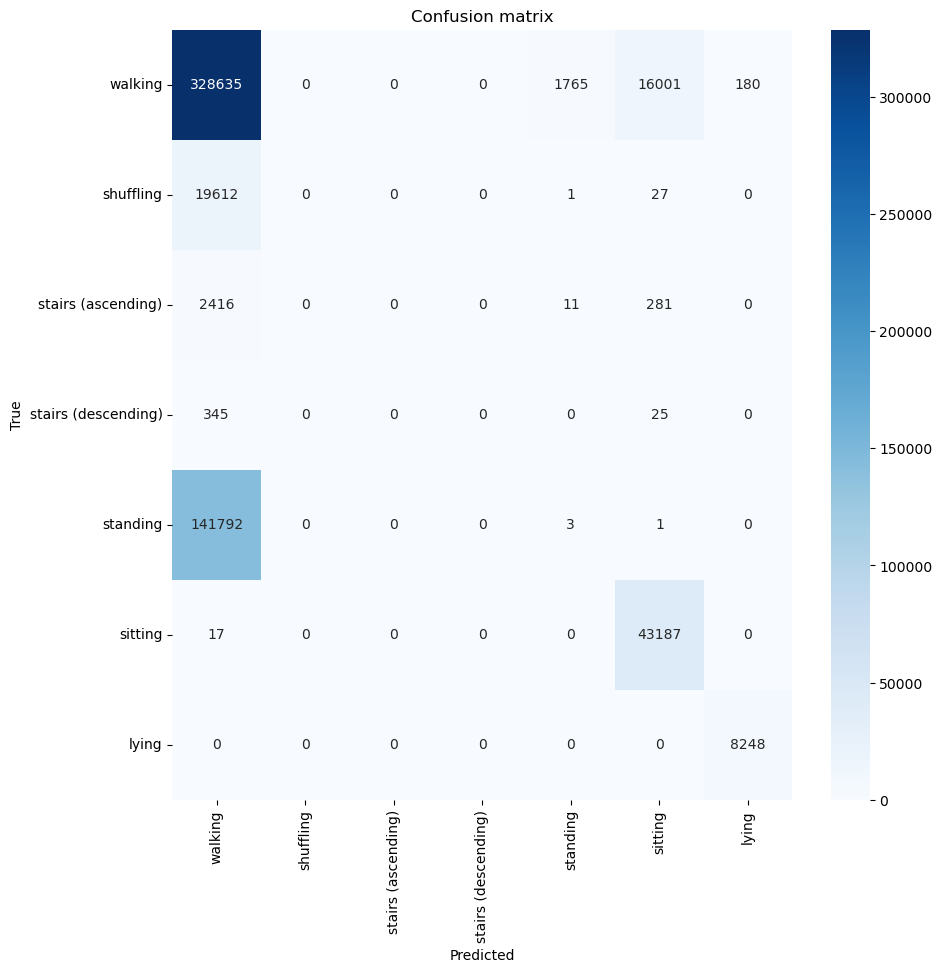

In [63]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

plt.figure(figsize=(10, 10))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

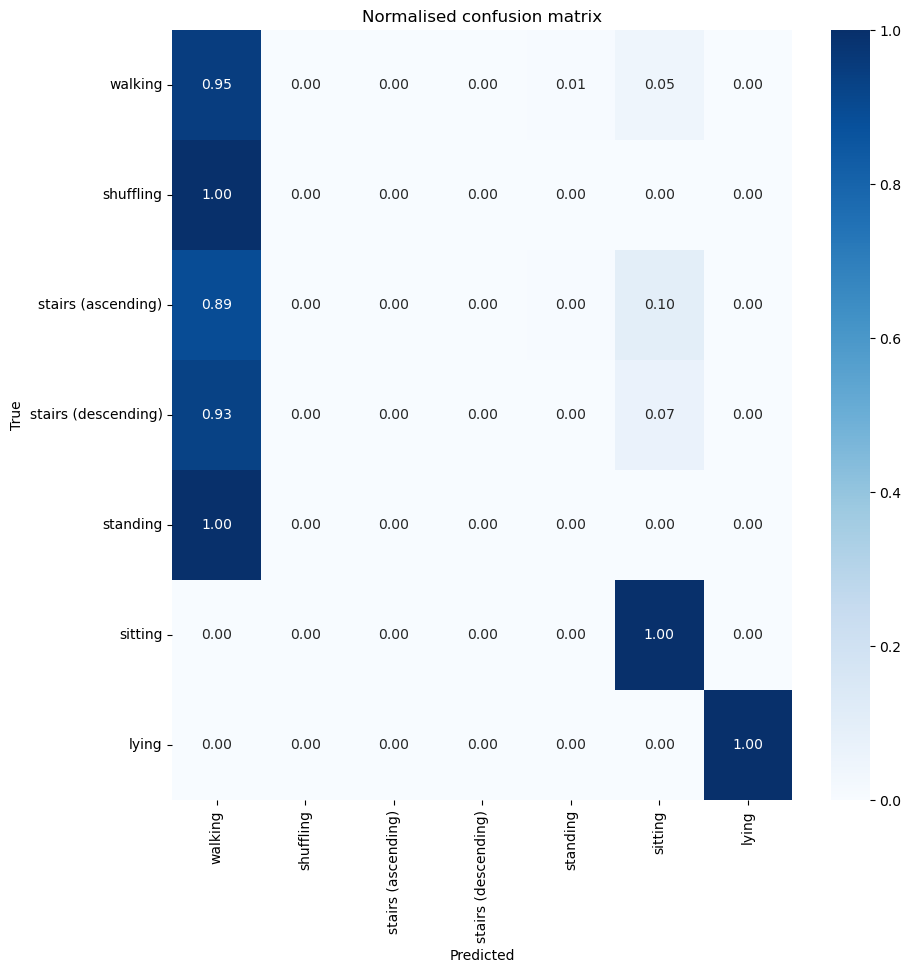

In [64]:
# Normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Normalised confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [65]:
# The performance of this model is on par with the windowed model
# Let's try with a variety of smoothing factors to see if we can improve the performance

alphas = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]

best_alphas_list = []
train_scores_list = []
test_scores_list = []
y_test_pred_decoded_list = []

for alpha in alphas:
    X_train_smoothed, y_train_smoothed, X_val_smoothed, y_val_smoothed, X_test_smoothed, y_test_smoothed = prepare_smoothed_data(alpha, X_train_scaled, y_train_encoded, X_val_scaled, y_val_encoded, X_test_scaled, y_test_encoded)

    ridge_alphas = np.logspace(-3, 3, 7)

    train_scores = []
    
    print(f"-------\nAlpha: {alpha}")

    for ridge_alpha in ridge_alphas:
        ridge = Ridge(alpha=ridge_alpha)
        ridge.fit(X_train_smoothed, y_train_smoothed)
        train_scores.append(ridge.score(X_val_smoothed, y_val_smoothed))

    train_scores_list.append(train_scores)
    
    best_alpha = ridge_alphas[np.argmax(train_scores)]
    best_alphas_list.append(best_alpha)

    print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")

    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train_smoothed, y_train_smoothed)
    test_score = ridge.score(X_test_smoothed, y_test_smoothed)
    
    test_scores_list.append(test_score)

    print(f"Test score: {test_score}")

    y_test_pred_encoded = ridge.predict(X_test_smoothed)
    y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

    y_test_pred_decoded_list.append(y_test_pred_decoded)

Smoothed train shape: (1357646, 6), (1357646, 7)
Smoothed val shape: (339404, 6), (339404, 7)
Smoothed test shape: (562547, 6), (562547, 7)
-------
Alpha: 0.001
Best alpha: 1000.0 with score: -0.1448332355895579
Test score: 0.07561218677910353
Smoothed train shape: (1357646, 6), (1357646, 7)
Smoothed val shape: (339404, 6), (339404, 7)
Smoothed test shape: (562547, 6), (562547, 7)
-------
Alpha: 0.01
Best alpha: 1000.0 with score: -0.1435934127821439
Test score: 0.07630451778293415
Smoothed train shape: (1357646, 6), (1357646, 7)
Smoothed val shape: (339404, 6), (339404, 7)
Smoothed test shape: (562547, 6), (562547, 7)
-------
Alpha: 0.1
Best alpha: 1000.0 with score: -0.1321929140515374
Test score: 0.0826341857210631
Smoothed train shape: (1357646, 6), (1357646, 7)
Smoothed val shape: (339404, 6), (339404, 7)
Smoothed test shape: (562547, 6), (562547, 7)
-------
Alpha: 0.2
Best alpha: 1000.0 with score: -0.12185458756491634
Test score: 0.08831849064341188
Smoothed train shape: (135764

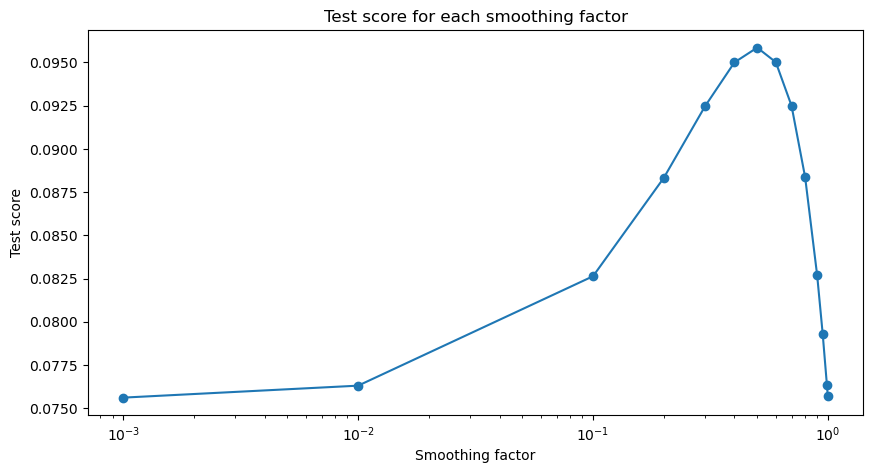

In [66]:
# Plot the test scores for each smoothing factor
plt.figure(figsize=(10, 5))
plt.plot(alphas, test_scores_list, marker='o')
plt.xlabel('Smoothing factor')
plt.ylabel('Test score')
plt.title('Test score for each smoothing factor')
plt.xscale('log')
plt.show()

In [67]:
# Print the classification report for each smoothing factor
for alpha, y_test_pred_decoded in zip(alphas, y_test_pred_decoded_list):
    print(f"Alpha: {alpha}")
    print(classification_report(y_test_decoded, y_test_pred_decoded))
    print()

Alpha: 0.001


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.72      1.00      0.84     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.67    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.67      0.56    562547


Alpha: 0.01


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.72      1.00      0.84     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.67    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.67      0.56    562547


Alpha: 0.1


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.73      1.00      0.84     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.68      0.56    562547


Alpha: 0.2


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.73      1.00      0.85     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.68      0.56    562547


Alpha: 0.3


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.74      1.00      0.85     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.38    562547
weighted avg       0.48      0.68      0.56    562547


Alpha: 0.4


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.79    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.74      1.00      0.85     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.38    562547
weighted avg       0.48      0.68      0.56    562547


Alpha: 0.5


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.79    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.74      1.00      0.85     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.38    562547
weighted avg       0.48      0.68      0.56    562547


Alpha: 0.6


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.74      1.00      0.85     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.38    562547
weighted avg       0.48      0.68      0.56    562547


Alpha: 0.7


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.74      1.00      0.85     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.68      0.56    562547


Alpha: 0.8


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.73      1.00      0.85     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.68      0.56    562547


Alpha: 0.9


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.73      1.00      0.84     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.68      0.56    562547


Alpha: 0.95


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.72      1.00      0.84     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.68      0.56    562547


Alpha: 0.99


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.72      1.00      0.84     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.67    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.67      0.56    562547


Alpha: 0.999


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.78    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.72      1.00      0.84     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.67    562547
   macro avg       0.34      0.42      0.37    562547
weighted avg       0.48      0.67      0.56    562547




C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


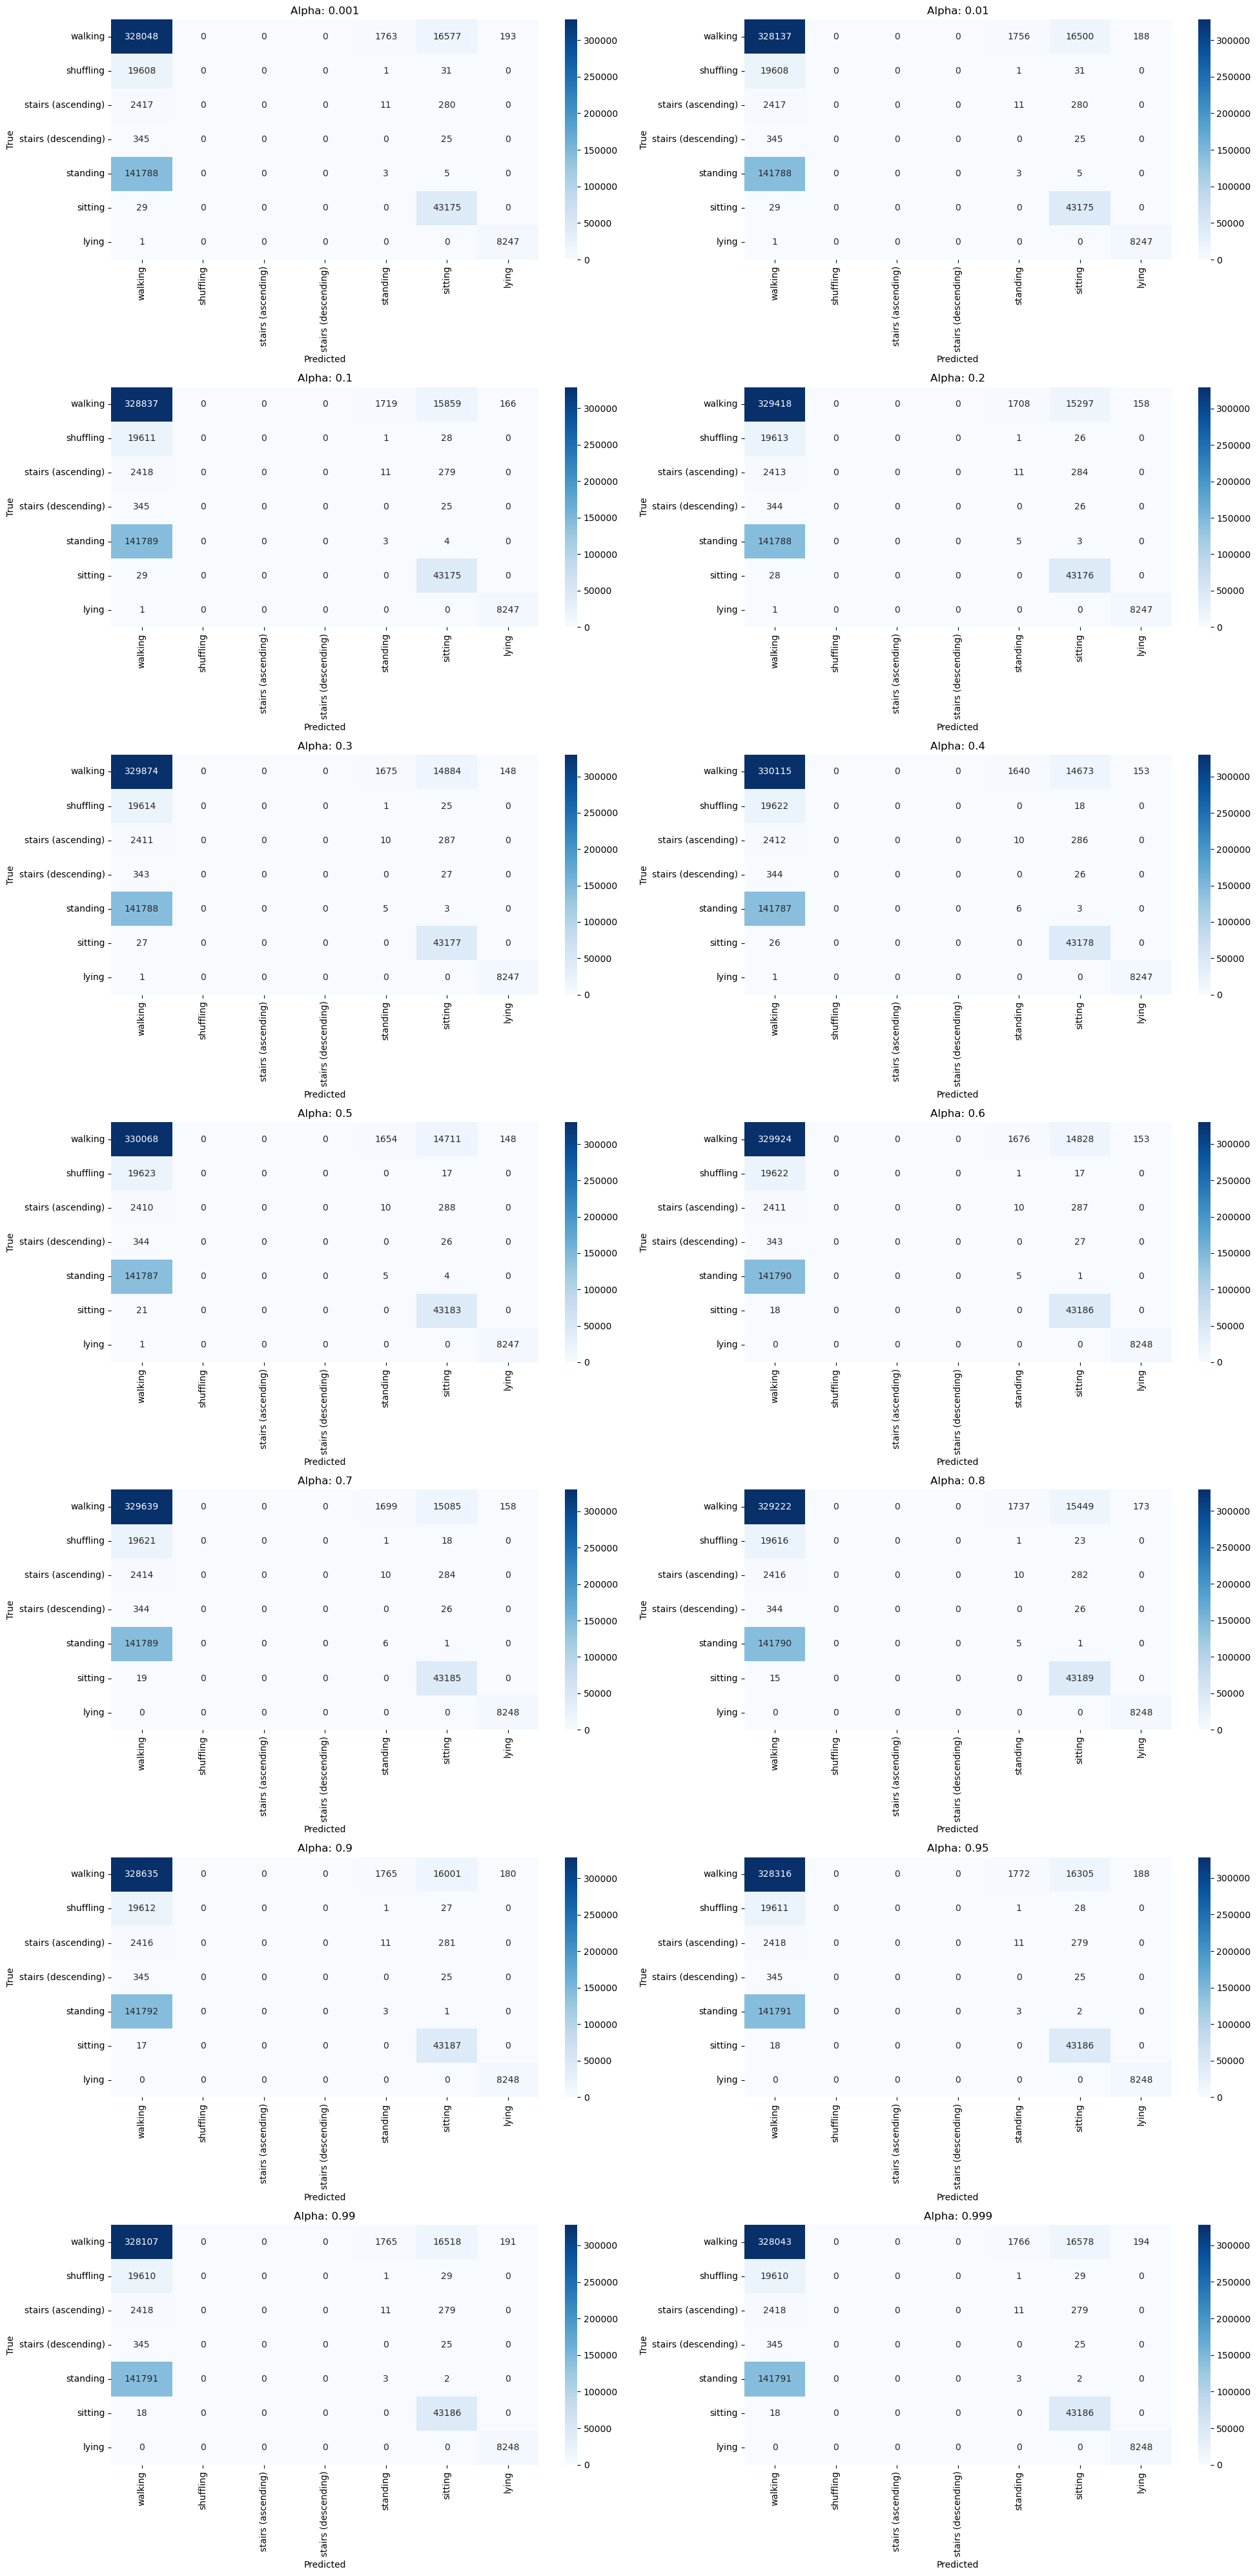

In [71]:
# Plot the confusion matrix for each smoothing factor
plt.figure(figsize=(20, 40))

for i, (alpha, y_test_pred_decoded) in enumerate(zip(alphas, y_test_pred_decoded_list)):
    conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

    plt.subplot(7, 2, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Alpha: {alpha}')
    
plt.tight_layout()
plt.show()

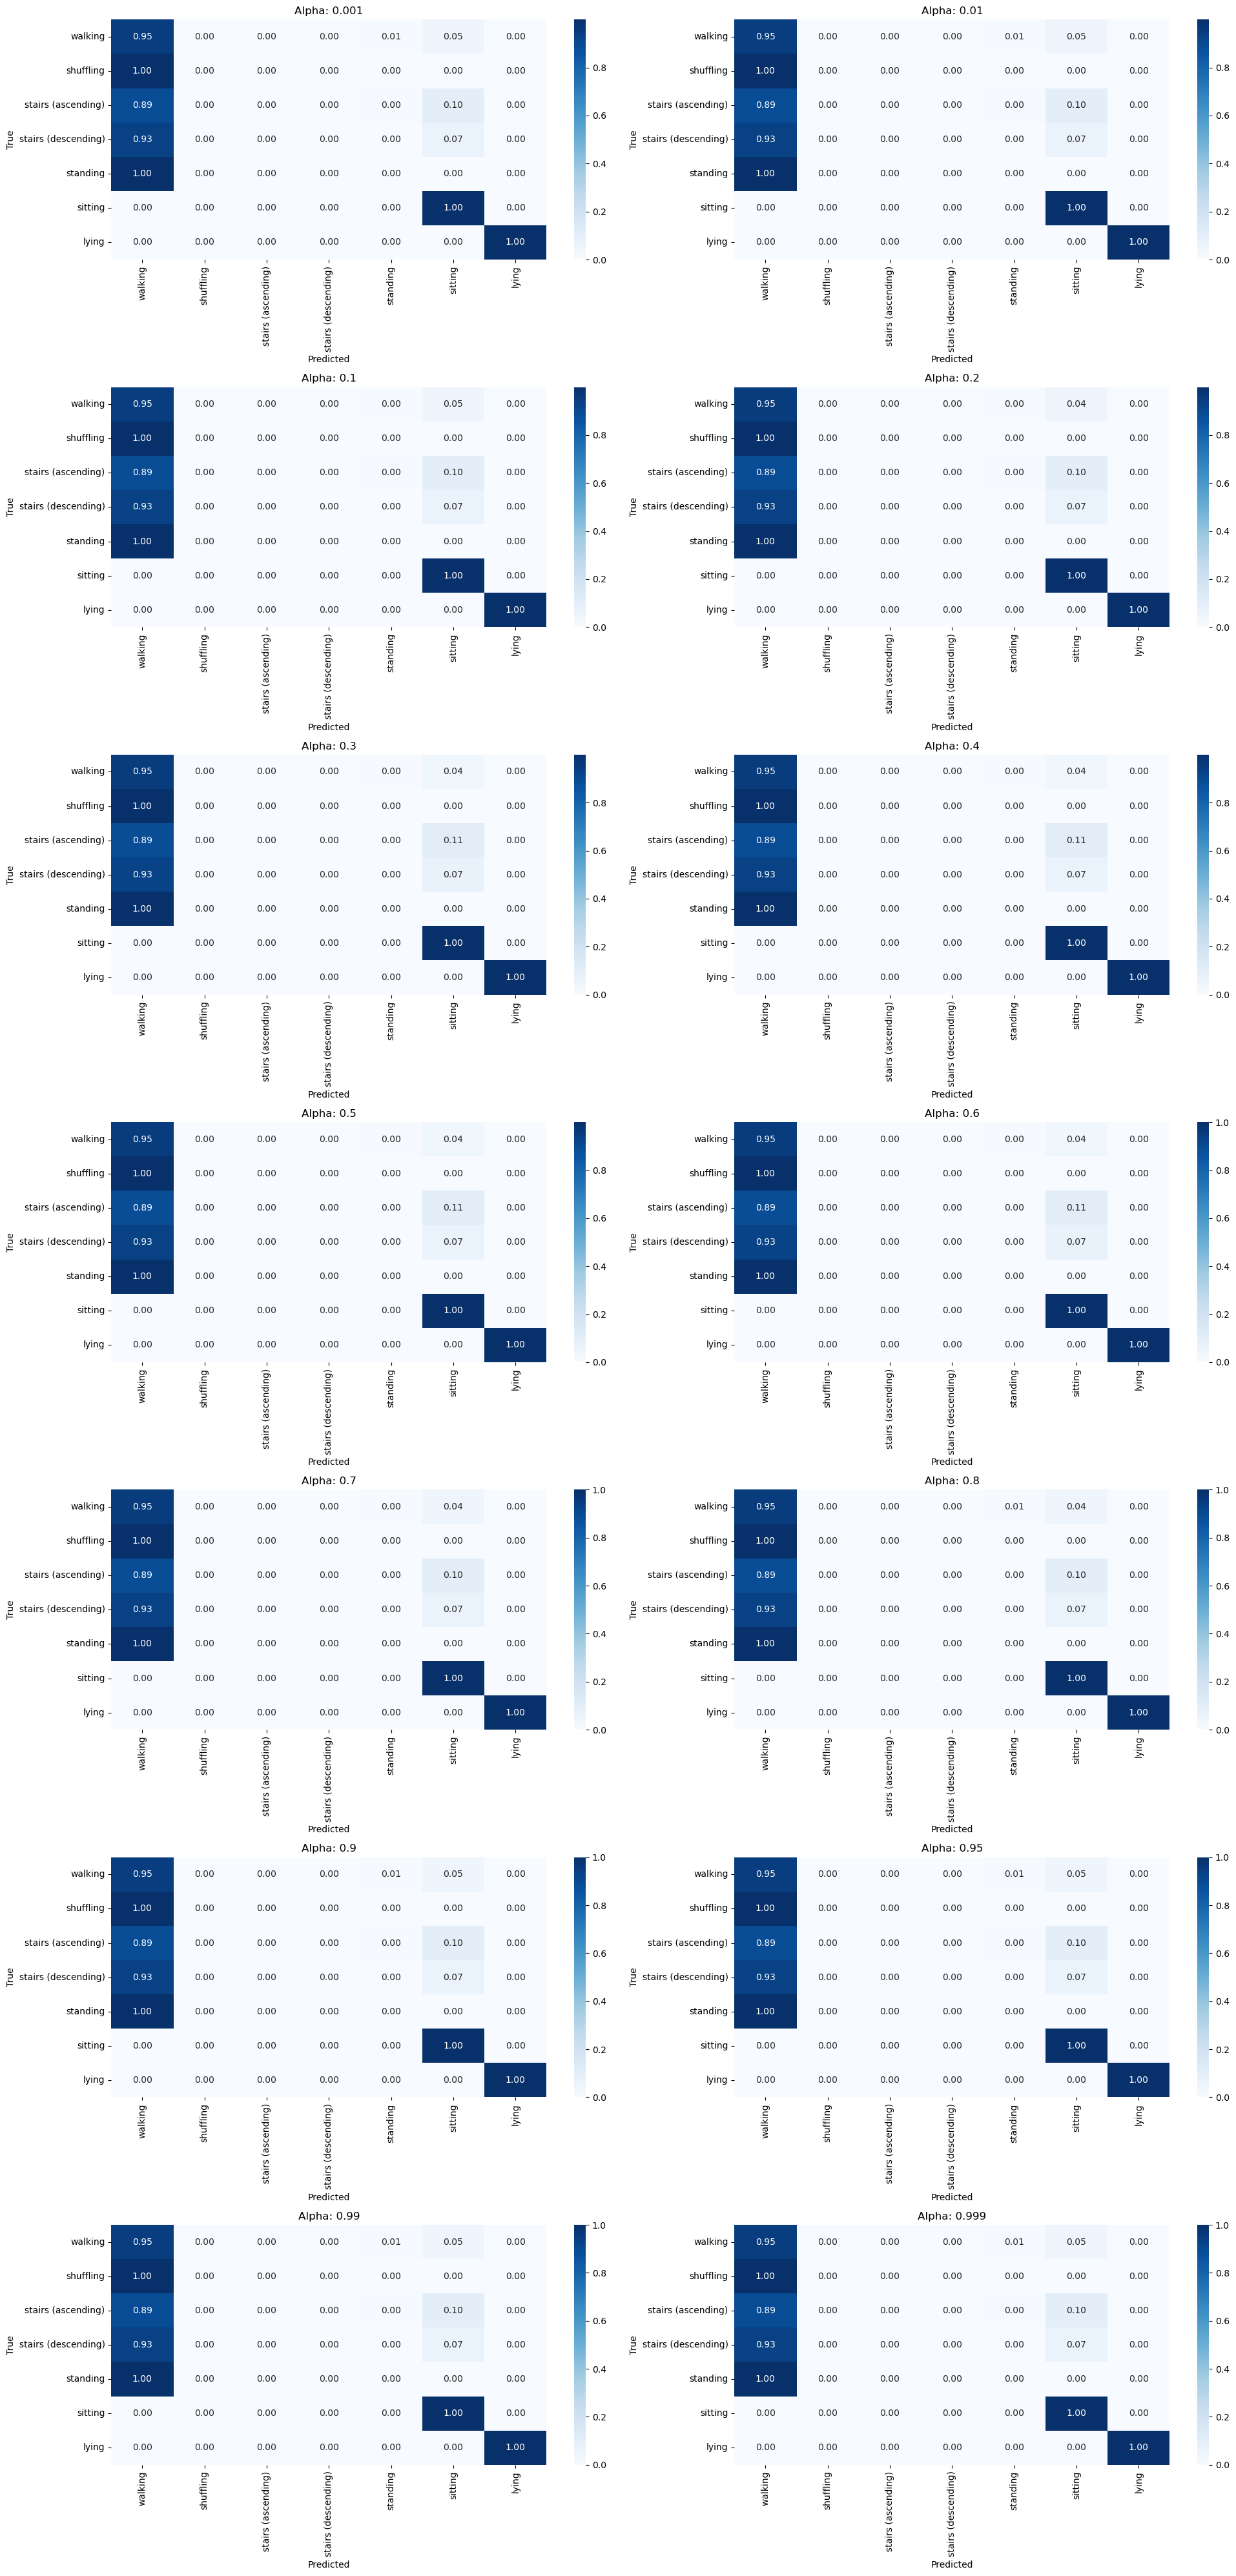

In [72]:
# Normalised confusion matrix for each smoothing factor

plt.figure(figsize=(20, 40))

for i, (alpha, y_test_pred_decoded) in enumerate(zip(alphas, y_test_pred_decoded_list)):
    conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.subplot(7, 2, i+1)
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title(f'Alpha: {alpha}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
plt.tight_layout()
plt.show()


In [73]:
# Select the best smoothing factor and alpha
best_smoothing_factor = alphas[np.argmax(test_scores_list)]
best_ridge_alpha = best_alphas_list[np.argmax(test_scores_list)]

print(f"Best smoothing factor: {best_smoothing_factor}, Best alpha: {best_ridge_alpha}")

Best smoothing factor: 0.5, Best alpha: 1000.0


In [74]:
gc.collect()

241432

In [75]:
# Now we can train the model on the best smoothing factor and alpha
X_train_smoothed, y_train_smoothed, X_val_smoothed, y_val_smoothed, X_test_smoothed, y_test_smoothed = prepare_smoothed_data(best_smoothing_factor, X_train_scaled, y_train_encoded, X_val_scaled, y_val_encoded, X_test_scaled, y_test_encoded)

ridge = Ridge(alpha=best_ridge_alpha)
ridge.fit(X_train_smoothed, y_train_smoothed)
test_score = ridge.score(X_test_smoothed, y_test_smoothed)

print(f"Test score: {test_score}")

Smoothed train shape: (1357646, 6), (1357646, 7)
Smoothed val shape: (339404, 6), (339404, 7)
Smoothed test shape: (562547, 6), (562547, 7)
Test score: 0.09585965951999612


In [76]:
# Evaluate the model using the decoded labels
y_test_pred_encoded = ridge.predict(X_test_smoothed)
y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

print(classification_report(y_test_decoded, y_test_pred_decoded))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.95      0.79    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.74      1.00      0.85     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.68    562547
   macro avg       0.34      0.42      0.38    562547
weighted avg       0.48      0.68      0.56    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


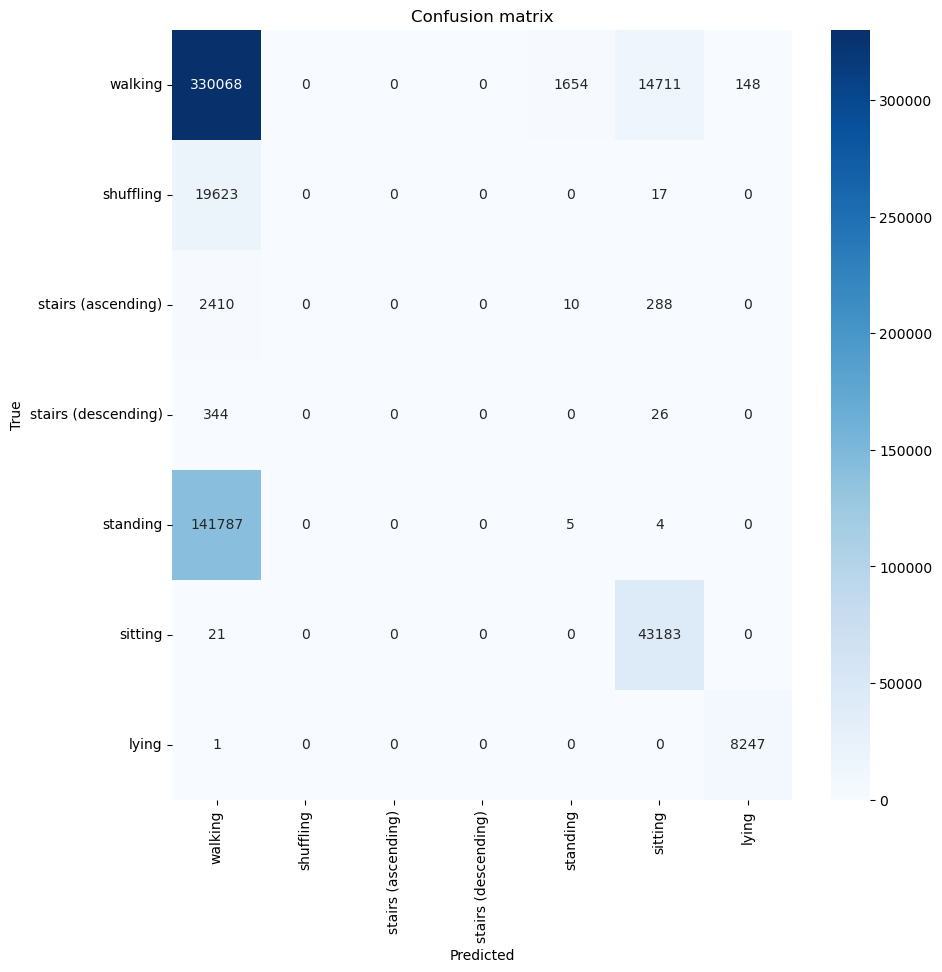

In [77]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

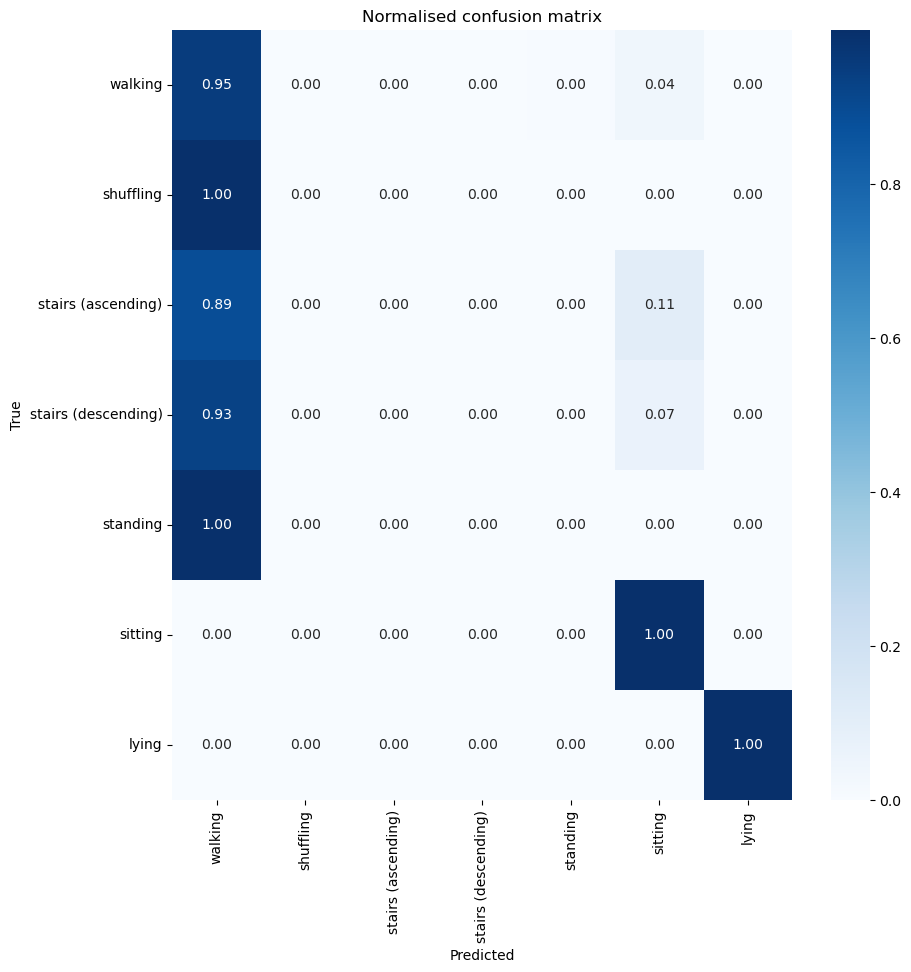

In [78]:
# Normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Normalised confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [79]:
# As the performance of these models seems to be similar to the windowing model, let's try combining the two. First, we will apply the exponential moving average, then we will apply the windowing technique
# This will allow the model to learn from the smoothed data, and also learn from the temporal information in the data

In [80]:
# Let's try to find the best combination of smoothing factor, window size, and alpha

window_sizes = [10, 50, 100, 500, 1000]
smoothing_factor = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]

best_alphas_list = []
train_scores_list = []
test_scores_list = []
y_test_pred_decoded_list = []

for window_size in window_sizes:
    for alpha in smoothing_factor:
        X_train_smoothed, y_train_smoothed, X_val_smoothed, y_val_smoothed, X_test_smoothed, y_test_smoothed = prepare_smoothed_data(alpha, X_train_scaled, y_train_encoded, X_val_scaled, y_val_encoded, X_test_scaled, y_test_encoded)
        X_train_buffered, y_train_buffered, X_val_buffered, y_val_buffered, X_test_buffered, y_test_buffered = prepare_buffered_data(window_size, X_train_smoothed, y_train_smoothed, X_val_smoothed, y_val_smoothed, X_test_smoothed, y_test_smoothed)

        ridge_alphas = np.logspace(-3, 3, 7)

        train_scores = []

        print(f"-------\nWindow size: {window_size}, Alpha: {alpha}")

        for ridge_alpha in ridge_alphas:
            ridge = Ridge(alpha=ridge_alpha)
            ridge.fit(X_train_buffered, y_train_buffered)
            train_scores.append(ridge.score(X_val_buffered, y_val_buffered))

        train_scores_list.append(train_scores)

        best_alpha = ridge_alphas[np.argmax(train_scores)]
        best_alphas_list.append(best_alpha)

        print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")

        ridge = Ridge(alpha=best_alpha)
        ridge.fit(X_train_buffered, y_train_buffered)
        test_score = ridge.score(X_test_buffered, y_test_buffered)

        test_scores_list.append(test_score)

        print(f"Test score: {test_score}")

        y_test_pred_encoded = ridge.predict(X_test_buffered)
        y_test_pred_encoded = y_test_pred_encoded.reshape(-1, n_classes)
        y_test_pred_encoded = y_test_pred_encoded[:y_test_encoded.shape[0]]
        y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

        y_test_pred_decoded_list.append(y_test_pred_decoded)
        
    # This is going to use a lot of memory, so let's call the garbage collector to free up some memory each iteration of window size
    gc.collect()
    

Smoothed train shape: (1357646, 6), (1357646, 7)
Smoothed val shape: (339404, 6), (339404, 7)
Smoothed test shape: (562547, 6), (562547, 7)
Buffered train shape: (135765, 60), (135765, 70)
Buffered val shape: (33941, 60), (33941, 70)
Buffered test shape: (56255, 60), (56255, 70)
-------
Window size: 10, Alpha: 0.001
Best alpha: 1.0 with score: 0.03335865111557705
Test score: 0.20642424206740925
Smoothed train shape: (1357646, 6), (1357646, 7)
Smoothed val shape: (339404, 6), (339404, 7)
Smoothed test shape: (562547, 6), (562547, 7)
Buffered train shape: (135765, 60), (135765, 70)
Buffered val shape: (33941, 60), (33941, 70)
Buffered test shape: (56255, 60), (56255, 70)
-------
Window size: 10, Alpha: 0.01
Best alpha: 1.0 with score: 0.0335408033407509
Test score: 0.20660983306284816
Smoothed train shape: (1357646, 6), (1357646, 7)
Smoothed val shape: (339404, 6), (339404, 7)
Smoothed test shape: (562547, 6), (562547, 7)
Buffered train shape: (135765, 60), (135765, 70)
Buffered val shap

In [81]:
# Our results lists are in the shape (n_window_sizes x n_smoothing_factors) so let's reshape the lists so that we can plot each window size as a separate line
train_scores_list = np.array(train_scores_list).reshape(len(window_sizes), len(smoothing_factor), -1)
test_scores_list = np.array(test_scores_list).reshape(len(window_sizes), len(smoothing_factor))
y_test_pred_decoded_list = np.array(y_test_pred_decoded_list).reshape(len(window_sizes), len(smoothing_factor), -1)

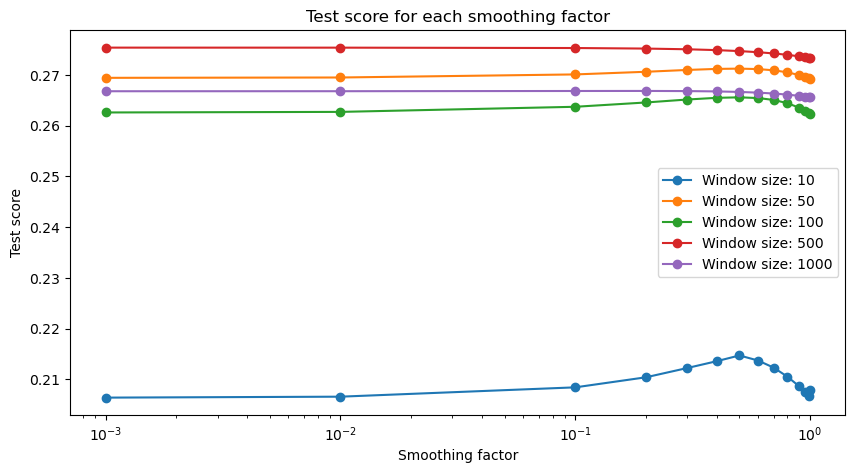

In [82]:
# Plot the test scores for each window size
plt.figure(figsize=(10, 5))

for i, window_size in enumerate(window_sizes):
    plt.plot(smoothing_factor, test_scores_list[i], marker='o', label=f'Window size: {window_size}')
    
plt.xlabel('Smoothing factor')
plt.ylabel('Test score')
plt.title('Test score for each smoothing factor')
plt.xscale('log')
plt.legend()
plt.show()

In [83]:
# There are too many combinations to print the classification report for each one, so let's just print the best one
best_window_size = window_sizes[np.argmax(test_scores_list.flatten()) // len(smoothing_factor)]
best_alpha = smoothing_factor[np.argmax(test_scores_list.flatten()) % len(smoothing_factor)]
best_ridge_alpha = best_alphas_list[np.argmax(test_scores_list.flatten())]

print(f"Best window size: {best_window_size}, Best smoothing factor: {best_alpha}, Best alpha: {best_ridge_alpha}")

Best window size: 500, Best smoothing factor: 0.001, Best alpha: 100.0


In [84]:
# Now we can train the model on the best window size, smoothing factor, and alpha
X_train_smoothed, y_train_smoothed, X_val_smoothed, y_val_smoothed, X_test_smoothed, y_test_smoothed = prepare_smoothed_data(best_alpha, X_train_scaled, y_train_encoded, X_val_scaled, y_val_encoded, X_test_scaled, y_test_encoded)

X_train_buffered, y_train_buffered, X_val_buffered, y_val_buffered, X_test_buffered, y_test_buffered = prepare_buffered_data(best_window_size, X_train_smoothed, y_train_smoothed, X_val_smoothed, y_val_smoothed, X_test_smoothed, y_test_smoothed)

ridge = Ridge(alpha=best_ridge_alpha)

ridge.fit(X_train_buffered, y_train_buffered)
test_score = ridge.score(X_test_buffered, y_test_buffered)

print(f"Test score: {test_score}")

Smoothed train shape: (1357646, 6), (1357646, 7)
Smoothed val shape: (339404, 6), (339404, 7)
Smoothed test shape: (562547, 6), (562547, 7)
Buffered train shape: (2716, 3000), (2716, 3500)
Buffered val shape: (679, 3000), (679, 3500)
Buffered test shape: (1126, 3000), (1126, 3500)
Test score: 0.2753804057152666


In [85]:
# Evaluate the model using the decoded labels
y_test_pred_encoded = ridge.predict(X_test_buffered)
y_test_pred_encoded = y_test_pred_encoded.reshape(-1, n_classes)
y_test_pred_encoded = y_test_pred_encoded[:y_test_encoded.shape[0]]
y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

print(classification_report(y_test_decoded, y_test_pred_decoded))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.70      0.99      0.82    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.86      0.11      0.20    141796
           7       0.99      0.99      0.99     43204
           8       1.00      0.99      1.00      8248

    accuracy                           0.73    562547
   macro avg       0.51      0.44      0.43    562547
weighted avg       0.74      0.73      0.65    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


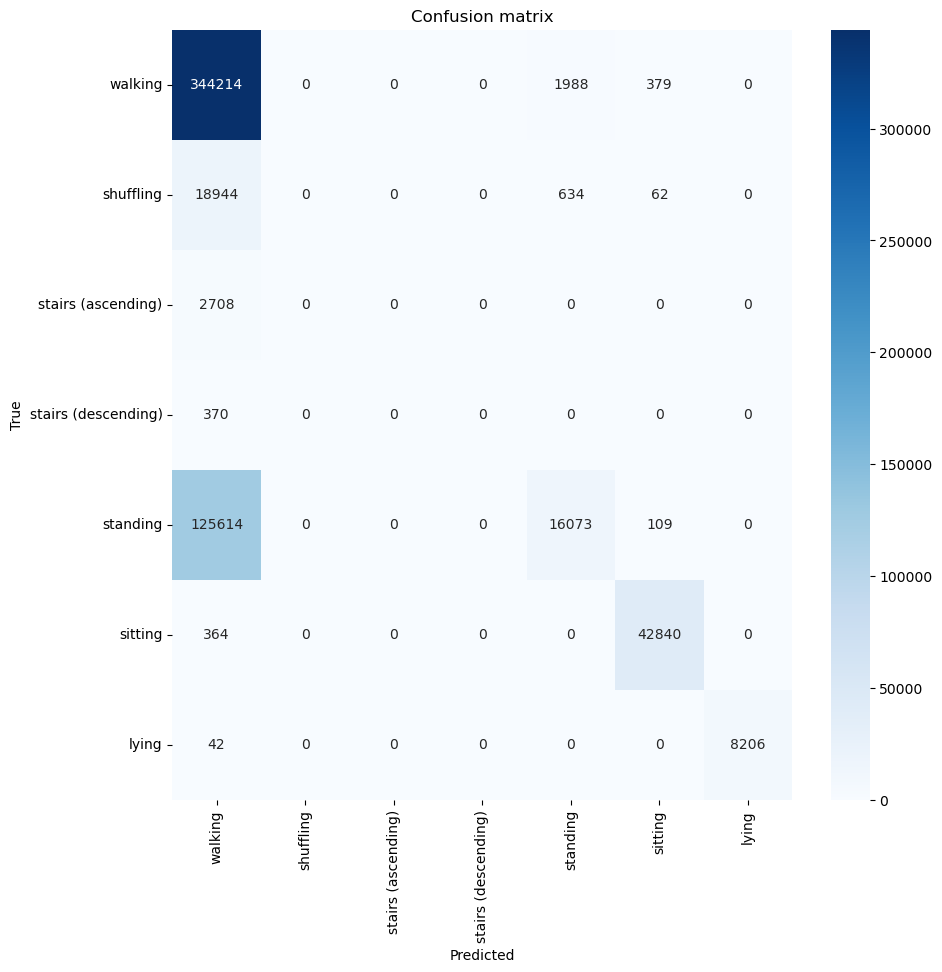

In [86]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

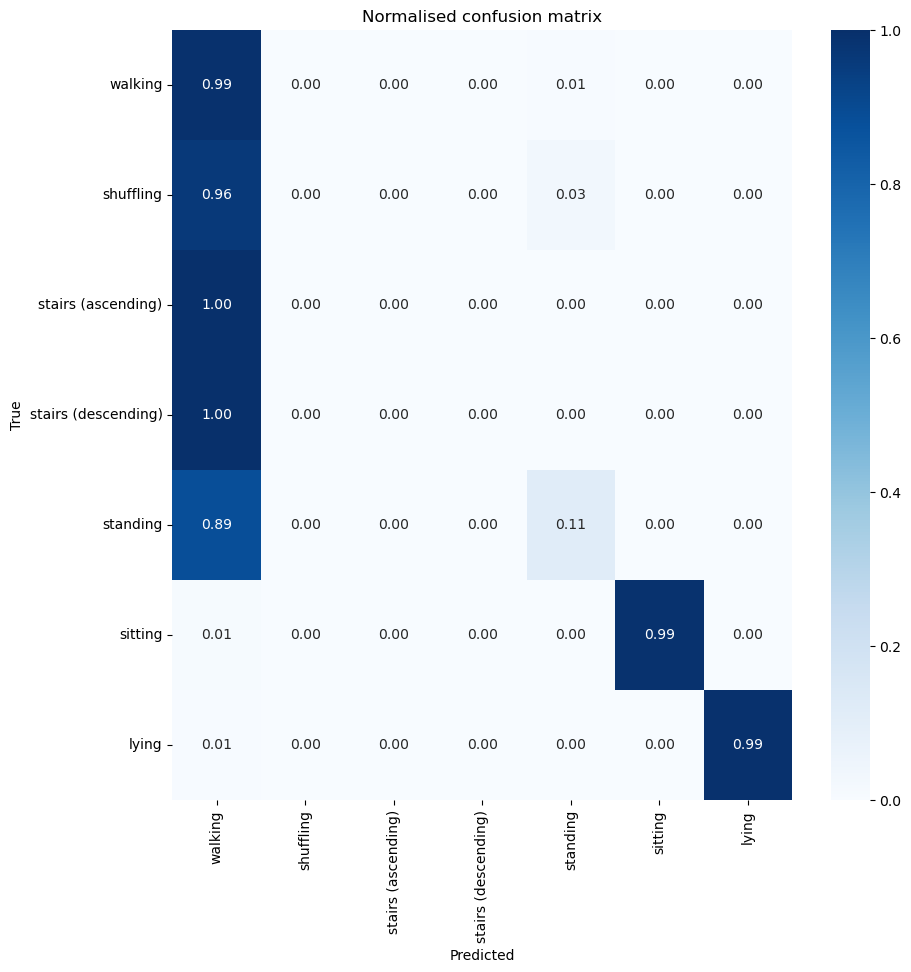

In [87]:
# Normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Normalised confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [87]:
# When combined together, the model does not perform any better than just using a larger window size
# It can be seen that the model is still struggling to predict the minority classes, but that the moving average has helped to improve the performance of the model when using a smaller window size
# This makes sense, as the moving average will help to smooth out the data, which will help the model to learn from the data, and effectively acts as a type of memory for the model

In [121]:
# It would be interesting to see how the model performs when using a fourier transform to extract the features before training the model
# We can use the fourier transform to de-noise the data and extract the most important features

def prepare_fourier_data(x_train, x_val, x_test, threshold=2e4):
    temp_x_train = np.array(x_train)
    temp_x_val = np.array(x_val)
    temp_x_test = np.array(x_test)
    
    # The fourier transform can be used to de-noise a signal by effectively removing the high frequency noise
    # This is essentially a low-pass filter
    
    # We need to carry this out on each feature separately as the fourier transform is applied to each feature
    datasets = [temp_x_train, temp_x_val, temp_x_test]
    fourier_datasets = []
    for dataset in datasets:
        # For each feature, we will apply the fourier transform
        fourier_dataset = np.zeros_like(dataset)
        for i in range(dataset.shape[1]):
            transformed_data = np.fft.rfft(dataset[:, i])
            frequencies = np.fft.rfftfreq(dataset.shape[0])
            transformed_data[frequencies > threshold] = 0
            smoothed_data = np.fft.irfft(transformed_data)
            # Check that the shape is the same, and if not, pad with zeros
            if smoothed_data.shape[0] < dataset.shape[0]:
                smoothed_data = np.pad(smoothed_data, (0, dataset.shape[0] - smoothed_data.shape[0]))
            fourier_dataset[:, i] = smoothed_data
            
        fourier_datasets.append(fourier_dataset)
        
    x_train_fourier = fourier_datasets[0]
    x_val_fourier = fourier_datasets[1]
    x_test_fourier = fourier_datasets[2]
    
    print(f"Fourier train shape: {x_train_fourier.shape}")
    print(f"Fourier val shape: {x_val_fourier.shape}")
    print(f"Fourier test shape: {x_test_fourier.shape}")
    
    return x_train_fourier, x_val_fourier, x_test_fourier

X_train_fourier, X_val_fourier, X_test_fourier = prepare_fourier_data(X_train_scaled, X_val_scaled, X_test_scaled, threshold=1e-2)

Fourier train shape: (1357646, 6)
Fourier val shape: (339404, 6)
Fourier test shape: (562547, 6)


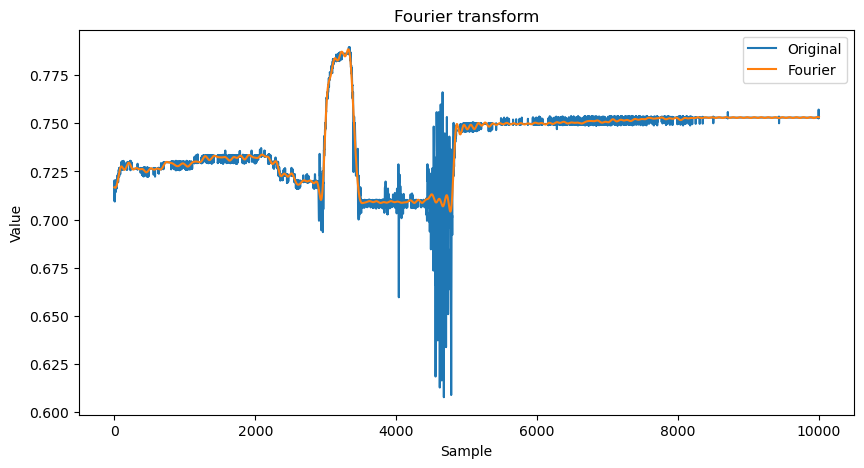

In [122]:
# Let's plot the first feature, and the smoothed feature to see how the fourier transform has affected the data
plt.figure(figsize=(10, 5))
plt.plot(X_train_scaled[:10000, 0], label='Original')
plt.plot(X_train_fourier[:10000, 0], label='Fourier')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Fourier transform')
plt.legend()
plt.show()


In [124]:
# Now we can train the ridge regression model on the fourier transformed data
ridge_alphas = np.logspace(-3, 3, 7)

train_scores = []

for alpha in ridge_alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_fourier, y_train_encoded)
    train_scores.append(ridge.score(X_val_fourier, y_val_encoded))
    
best_alpha = ridge_alphas[np.argmax(train_scores)]

print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")


Best alpha: 0.001 with score: 0.1324129426631257


In [125]:
# Evaluate the model using the decoded labels
y_test_pred_encoded = ridge.predict(X_test_fourier)
y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

print(classification_report(y_test_decoded, y_test_pred_decoded))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.68      1.00      0.81    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       1.00      0.03      0.05    141796
           7       1.00      1.00      1.00     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.71    562547
   macro avg       0.53      0.43      0.41    562547
weighted avg       0.76      0.71      0.60    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


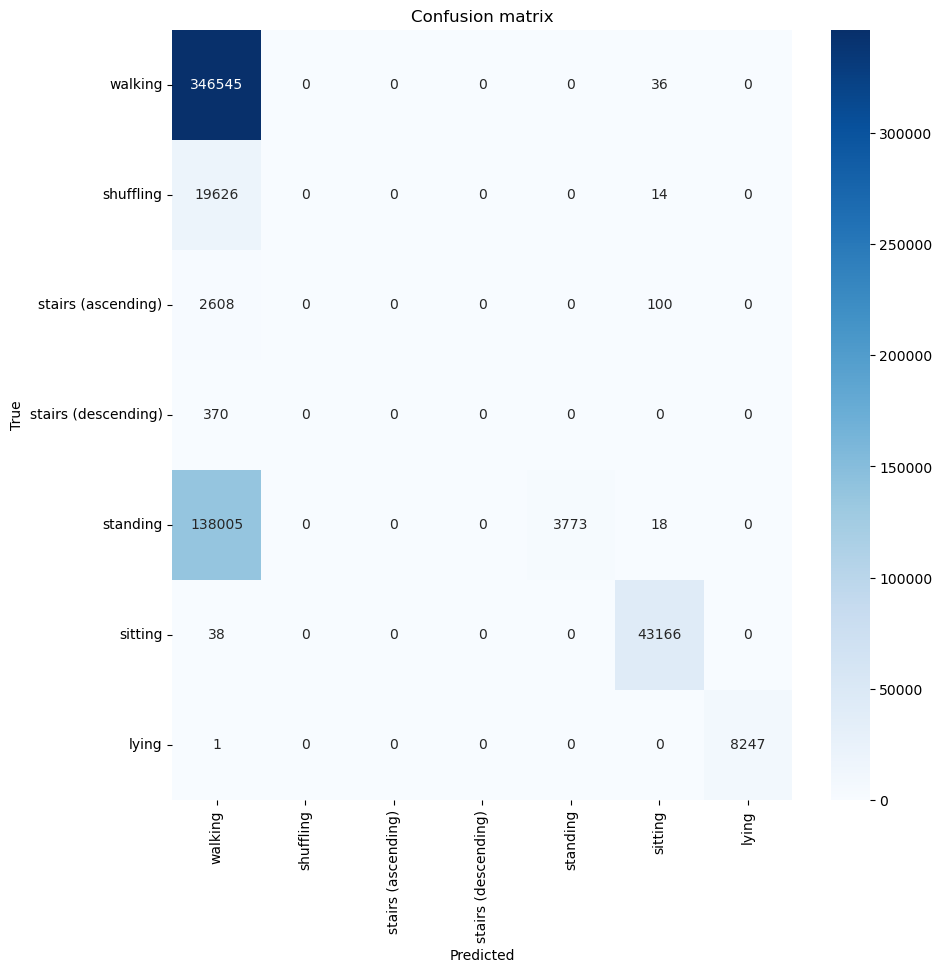

In [126]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()


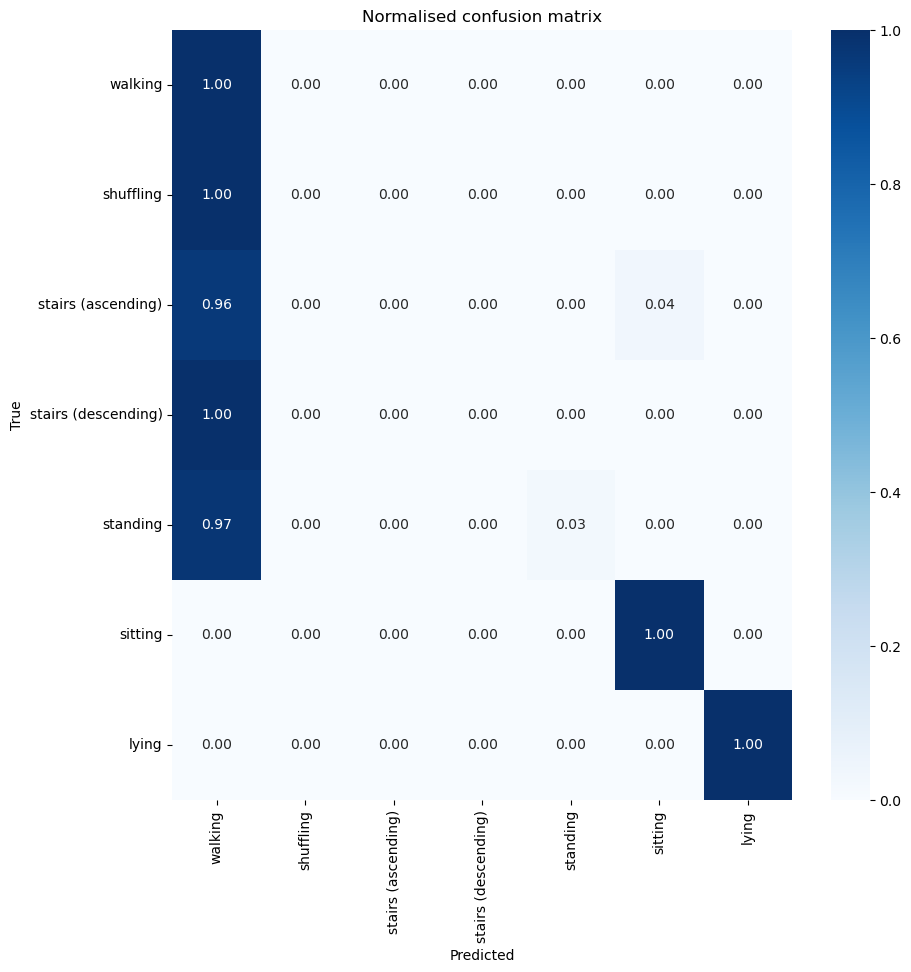

In [127]:
#   Normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Normalised confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [128]:
# Let's try a variety of thresholds to see if we can improve the performance
thresholds = [1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

best_alphas_list = []
train_scores_list = []
test_scores_list = []
y_test_pred_decoded_list = []

for threshold in thresholds:
    X_train_fourier, X_val_fourier, X_test_fourier = prepare_fourier_data(X_train_scaled, X_val_scaled, X_test_scaled, threshold=threshold)

    ridge_alphas = np.logspace(-3, 3, 7)

    train_scores = []

    print(f"-------\nThreshold: {threshold}")

    for alpha in ridge_alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_fourier, y_train_encoded)
        train_scores.append(ridge.score(X_val_fourier, y_val_encoded))

    train_scores_list.append(train_scores)

    best_alpha = ridge_alphas[np.argmax(train_scores)]
    best_alphas_list.append(best_alpha)

    print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")

    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train_fourier, y_train_encoded)
    test_score = ridge.score(X_test_fourier, y_test_encoded)

    test_scores_list.append(test_score)

    print(f"Test score: {test_score}")

    y_test_pred_encoded = ridge.predict(X_test_fourier)
    y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

    y_test_pred_decoded_list.append(y_test_pred_decoded)

Fourier train shape: (1357646, 6)
Fourier val shape: (339404, 6)
Fourier test shape: (562547, 6)
-------
Threshold: 100.0
Best alpha: 1000.0 with score: -0.1449247682456268
Test score: 0.07543634010880683
Fourier train shape: (1357646, 6)
Fourier val shape: (339404, 6)
Fourier test shape: (562547, 6)
-------
Threshold: 10.0
Best alpha: 1000.0 with score: -0.1449247682456268
Test score: 0.07543634010880683
Fourier train shape: (1357646, 6)
Fourier val shape: (339404, 6)
Fourier test shape: (562547, 6)
-------
Threshold: 1.0
Best alpha: 1000.0 with score: -0.1449247682456268
Test score: 0.07543634010880683
Fourier train shape: (1357646, 6)
Fourier val shape: (339404, 6)
Fourier test shape: (562547, 6)
-------
Threshold: 0.1
Best alpha: 1000.0 with score: -0.05044728111445708
Test score: 0.12674641046089488
Fourier train shape: (1357646, 6)
Fourier val shape: (339404, 6)
Fourier test shape: (562547, 6)
-------
Threshold: 0.01
Best alpha: 0.001 with score: 0.1324129426631257
Test score: 0.

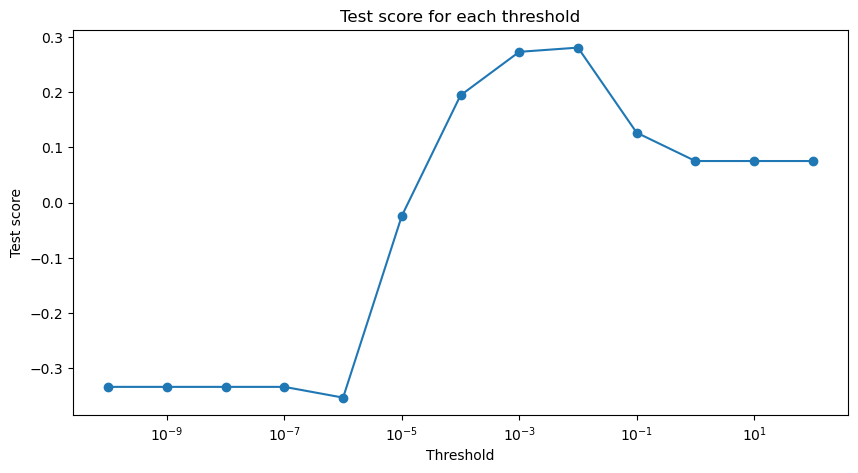

In [129]:
# Plot the test scores for each threshold
plt.figure(figsize=(10, 5))

plt.plot(thresholds, test_scores_list, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Test score')
plt.title('Test score for each threshold')
plt.xscale('log')
plt.show()

In [130]:
# There are too many combinations to print the classification report for each one, so let's just print the best one
best_threshold = thresholds[np.argmax(test_scores_list)]
best_alpha = best_alphas_list[np.argmax(test_scores_list)]

print(f"Best threshold: {best_threshold}, Best alpha: {best_alpha}")

Best threshold: 0.01, Best alpha: 0.001


In [131]:
# Now we can train the model on the best threshold and alpha
X_train_fourier, X_val_fourier, X_test_fourier = prepare_fourier_data(X_train_scaled, X_val_scaled, X_test_scaled, threshold=best_threshold)

ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_fourier, y_train_encoded)
test_score = ridge.score(X_test_fourier, y_test_encoded)

print(f"Test score: {test_score}")

Fourier train shape: (1357646, 6)
Fourier val shape: (339404, 6)
Fourier test shape: (562547, 6)
Test score: 0.2806899967341049


In [132]:
# Evaluate the model using the decoded labels
y_test_pred_encoded = ridge.predict(X_test_fourier)
y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

print(classification_report(y_test_decoded, y_test_pred_decoded))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.72      0.98      0.83    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.83      0.21      0.34    141796
           7       1.00      1.00      1.00     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.75    562547
   macro avg       0.51      0.46      0.45    562547
weighted avg       0.74      0.75      0.69    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


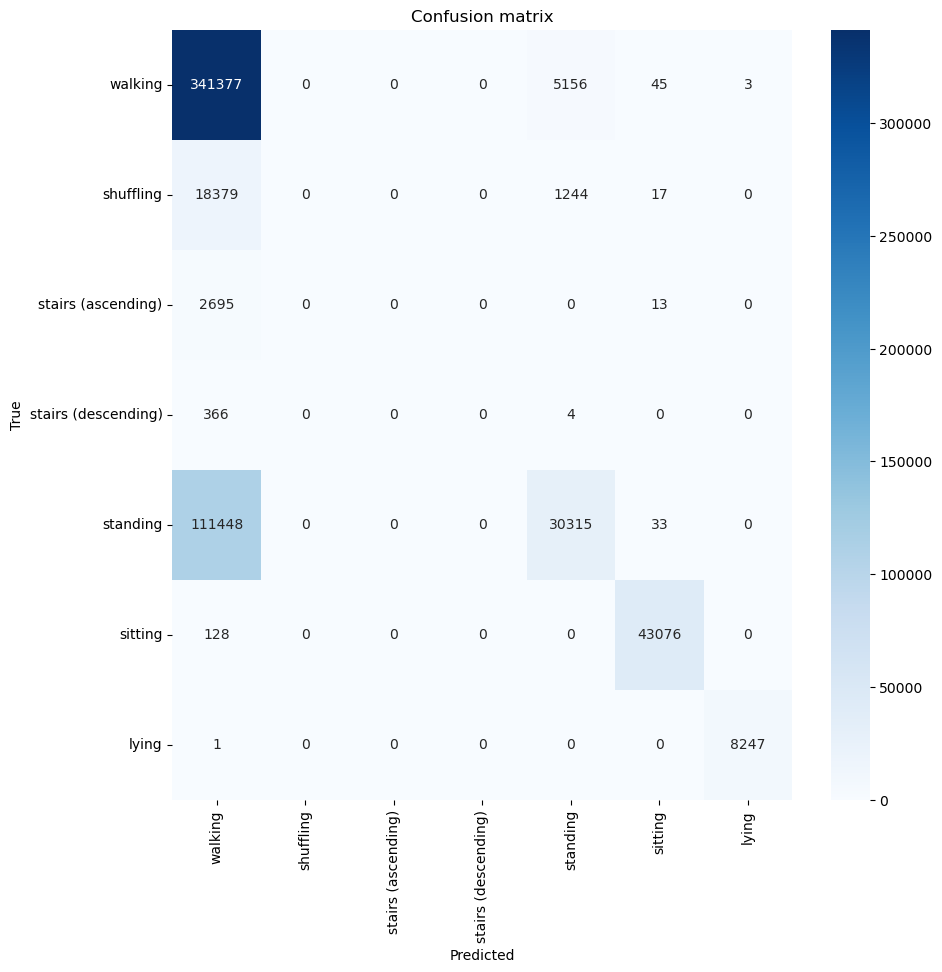

In [133]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

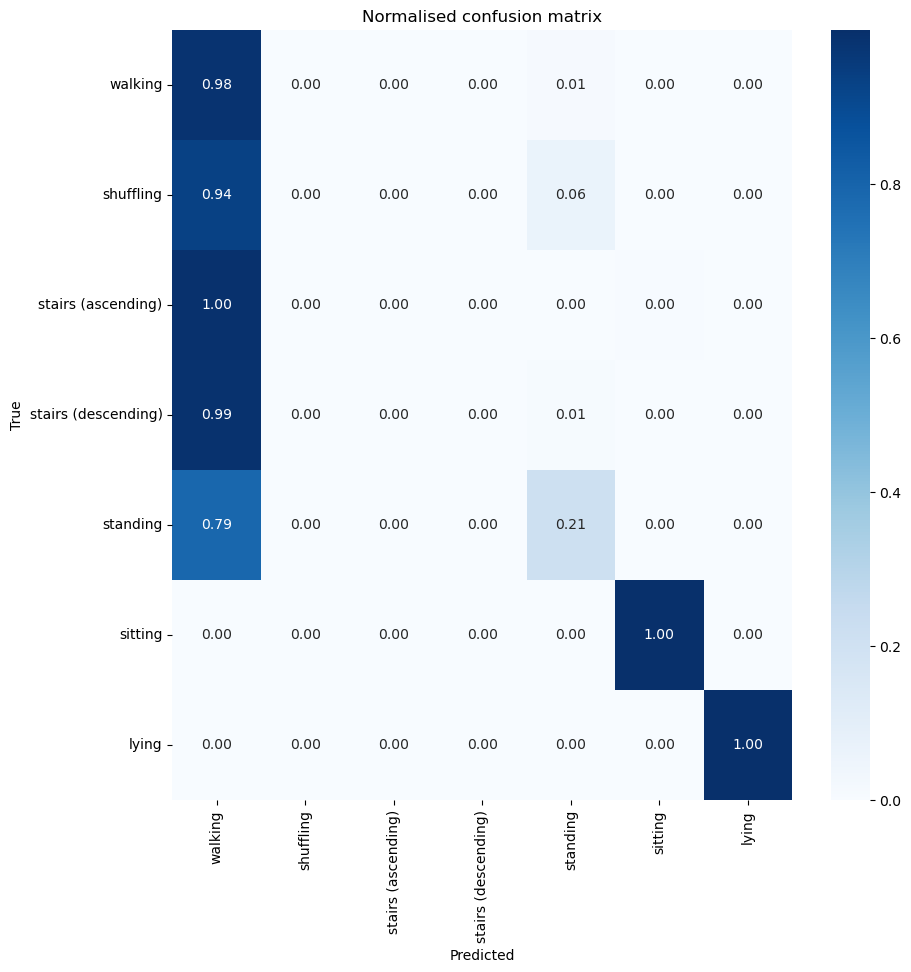

In [134]:
# Normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Normalised confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [135]:
# Let's try combining this with a windowing technique to see if we can improve the performance
window_sizes = [10, 50, 100, 500, 1000]

best_alphas_list = []
train_scores_list = []
test_scores_list = []
y_test_pred_decoded_list = []

for window_size in window_sizes:
    X_train_fourier, X_val_fourier, X_test_fourier = prepare_fourier_data(X_train_scaled, X_val_scaled, X_test_scaled, threshold=best_threshold)
    X_train_buffered, y_train_buffered, X_val_buffered, y_val_buffered, X_test_buffered, y_test_buffered = prepare_buffered_data(window_size, X_train_fourier, y_train_encoded, X_val_fourier, y_val_encoded, X_test_fourier, y_test_encoded)

    ridge_alphas = np.logspace(-3, 3, 7)

    train_scores = []

    print(f"-------\nWindow size: {window_size}")

    for alpha in ridge_alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_buffered, y_train_buffered)
        train_scores.append(ridge.score(X_val_buffered, y_val_buffered))

    train_scores_list.append(train_scores)

    best_alpha = ridge_alphas[np.argmax(train_scores)]
    best_alphas_list.append(best_alpha)

    print(f"Best alpha: {best_alpha} with score: {train_scores[np.argmax(train_scores)]}")

    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train_buffered, y_train_buffered)
    test_score = ridge.score(X_test_buffered, y_test_buffered)

    test_scores_list.append(test_score)

    print(f"Test score: {test_score}")

    y_test_pred_encoded = ridge.predict(X_test_buffered)
    y_test_pred_encoded = y_test_pred_encoded.reshape(-1, n_classes)
    y_test_pred_encoded = y_test_pred_encoded[:y_test_encoded.shape[0]]
    y_test_pred_decoded = encoder.inverse_transform(y_test_pred_encoded)

    y_test_pred_decoded_list.append(y_test_pred_decoded)
    
    # This is going to use a lot of memory, so let's call the garbage collector to free up some memory each iteration of window size
    gc.collect()
    

Fourier train shape: (1357646, 6)
Fourier val shape: (339404, 6)
Fourier test shape: (562547, 6)
Buffered train shape: (135765, 60), (135765, 70)
Buffered val shape: (33941, 60), (33941, 70)
Buffered test shape: (56255, 60), (56255, 70)
-------
Window size: 10
Best alpha: 0.001 with score: 0.13420364708482171
Test score: 0.17463123813071832
Fourier train shape: (1357646, 6)
Fourier val shape: (339404, 6)
Fourier test shape: (562547, 6)
Buffered train shape: (27153, 300), (27153, 350)
Buffered val shape: (6789, 300), (6789, 350)
Buffered test shape: (11251, 300), (11251, 350)
-------
Window size: 50
Best alpha: 0.001 with score: 0.13535448125140484
Test score: 0.1396098296339432
Fourier train shape: (1357646, 6)
Fourier val shape: (339404, 6)
Fourier test shape: (562547, 6)
Buffered train shape: (13577, 600), (13577, 700)
Buffered val shape: (3395, 600), (3395, 700)
Buffered test shape: (5626, 600), (5626, 700)
-------
Window size: 100
Best alpha: 0.001 with score: 0.13664966106632123
T

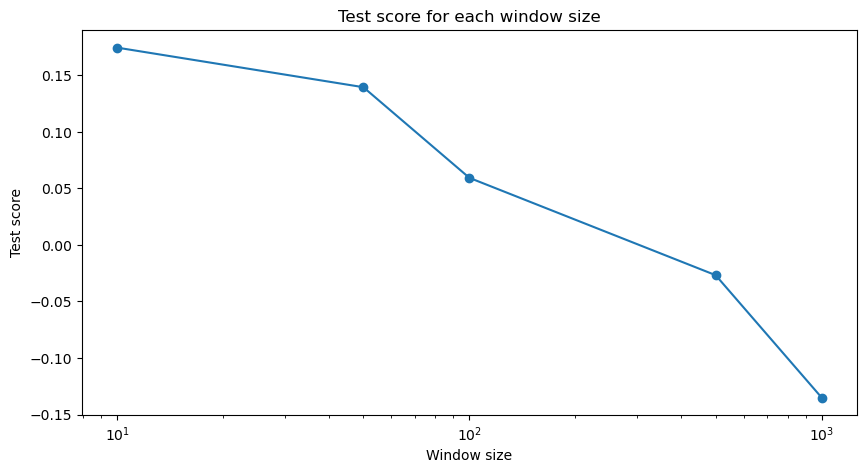

In [136]:
# Plot the test scores for each window size
plt.figure(figsize=(10, 5))

plt.plot(window_sizes, test_scores_list, marker='o')
plt.xlabel('Window size')
plt.ylabel('Test score')
plt.title('Test score for each window size')
plt.xscale('log')
plt.show()